# Car accident

In [45]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.font_manager
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import matplotlib.colors as mcolors
import datetime
import os
from tueplots import bundles
from tueplots.constants.color import rgb
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.linear_model import LinearRegression
import seaborn as sns
import geopandas
import contextily as cx
import logging
from matplotlib_venn import venn3, venn3_circles

#removes annoying font not found warning
#logging.getLogger('matplotlib').setLevel(level=logging.CRITICAL)

plt.rcParams.update(bundles.icml2022(column='full',nrows=1,ncols=2,usetex=False))

matplotlib.rcParams['font.family'] = ['serif']
matplotlib.rcParams['font.serif'] = ['Times New Roman']
#plt.rcParams['font.size'] = 100

#matplotlib.rc('font',size=40)
#matplotlib.rcParams.update({'font.zize':10})

#plt.rcParams.update(bundles.beamer_moml())
#plt.rcParams.update({"figure.dpi": 200})
#plt.rcParams["axes.unicode_minus"] = False


SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14
plt.rc('font', size = SMALL_SIZE) # Default text sizes
plt.rc('axes', titlesize = SMALL_SIZE) # Font size
plt.rc('axes', labelsize = MEDIUM_SIZE) # Font size
plt.rc('xtick', labelsize = SMALL_SIZE) # Font size
plt.rc('ytick', labelsize = SMALL_SIZE) # Font size
plt.rc('legend', fontsize = SMALL_SIZE) # Font size
plt.rc('figure', titlesize = BIGGER_SIZE) # Font size


#plt.rcParams["font.family"] = 'monospace' ## I just use this to get rid of the annoying font family error

#/usr/share/fonts/truetype/msttcorefonts/times.ttf

if not os.path.exists('plots'):
    os.mkdir('plots')
for folder in ['human error','time plot','geo plot']:
    if not os.path.exists('plots/'+folder):
        os.mkdir('plots/'+folder)
if not os.path.exists('data'):
    os.mkdir('data')

# change to enable or disable graph export
save_fig = True

In [31]:
# Import accident datasets
# https://www.nhtsa.gov/file-downloads?p=nhtsa/downloads/FARS/2020/National/
# Adjust nrows only for testing purposes (faster testing of new code)
path = 'data/FARS2021NationalCSV/'
nrows = None

accidents = pd.read_csv(path + 'accident.csv',encoding='WINDOWS-1252',nrows=nrows)
drimpair = pd.read_csv(path + 'drimpair.csv',encoding='WINDOWS-1252',nrows=nrows).groupby(['ST_CASE','VEH_NO']).first().reset_index()
driverrf = pd.read_csv(path + 'driverrf.csv',encoding='WINDOWS-1252',nrows=nrows).groupby(['ST_CASE','VEH_NO']).first().reset_index()
vehicle = pd.read_csv(path + 'vehicle.csv',encoding='WINDOWS-1252',nrows=nrows).groupby(['ST_CASE','VEH_NO']).first().reset_index() #, usecols=['ST_CASE','VEH_NO','DR_DRINK','L_TYPE','L_STATUS','CDL_STAT','SPEEDREL']
person = pd.read_csv(path + 'person.csv',encoding='WINDOWS-1252',nrows=nrows)  # ,usecols=['ST_CASE','PER_TYP','SEX','VEH_NO','PER_NO','AGE','SEXNAME','DRINKINGNAME','ALC_DETNAME','ALC_STATUSNAME','ATST_TYPNAME','ALC_RES','ALC_RESNAME','DRUGS','DRUGSNAME','DRUG_DET','DRUG_DETNAME'])
crashrf = pd.read_csv(path + 'crashrf.csv',encoding='WINDOWS-1252',nrows=nrows).groupby('ST_CASE').first().reset_index()
accidents = pd.merge(accidents,drimpair.loc[:,'ST_CASE':],on=['ST_CASE'])
accidents = pd.merge(accidents,crashrf.loc[:,'ST_CASE':],on=['ST_CASE'],suffixes=('', '_y'))
accidents.drop(accidents.filter(regex='_y$').columns, axis=1, inplace=True)
accidents = pd.merge(accidents,driverrf.loc[:,'ST_CASE':],on=['ST_CASE','VEH_NO'],suffixes=('', '_y'))
accidents.drop(accidents.filter(regex='_y$').columns, axis=1, inplace=True)
accidents = pd.merge(accidents,vehicle.loc[:,'ST_CASE':],on=['ST_CASE','VEH_NO'],suffixes=('', '_y'))
accidents.drop(accidents.filter(regex='_y$').columns, axis=1, inplace=True)
accidents = pd.merge(accidents,person.loc[:,'ST_CASE':],on=['ST_CASE','VEH_NO'],suffixes=('', '_y'))
accidents.drop(accidents.filter(regex='_y$').columns, axis=1, inplace=True)
del drimpair, driverrf, vehicle, person, crashrf
accidents['date'] = pd.to_datetime(accidents[['YEAR','MONTH','DAY']])
print('accident data import completed')


# import inhabitants Dataset
# https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/counties/totals/co-est2021-alldata.csv
path = 'data/'
people = pd.read_csv(path + 'people.csv',index_col=0)
print('people import completed')
accidents.drop(accidents.filter(regex='_y$').columns, axis=1, inplace=True)

# Import Google Dataset
# https://storage.googleapis.com/covid19-open-data/v2/main.csv
#reduziere Spalten für geringere RAM Nutzung
usecols = ['key','date','country_code','country_name','subregion1_code','subregion1_name','subregion2_code','subregion2_name',
               'population','population_male','population_female','rural_population','urban_population','largest_city_population','clustered_population','population_density','population_age_00_09','population_age_10_19','population_age_20_29','population_age_30_39','population_age_40_49','population_age_50_59','population_age_60_69','population_age_70_79','population_age_80_89','population_age_90_99','population_age_80_and_older',
               'area','rural_area','urban_area','latitude','longitude',
               'average_temperature','minimum_temperature','maximum_temperature','rainfall','snowfall','dew_point','relative_humidity']
Google_daten = pd.read_csv(path + 'Google_daten(US).csv',parse_dates=['date'],index_col=0,usecols=usecols)
print('Google daten import completed')


# Import USA geo datasets
# https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
US_state_shape = geopandas.read_file('data/States shape data/cb_2018_us_state_500k.shp')
US_county_shape = geopandas.read_file('data/County shape data/cb_2018_us_county_500k.shp')
US_state_shape['STATENAME'] = US_state_shape['NAME']
print('Geodata import completed')

#remove unnecessary data
Google_daten = Google_daten[Google_daten['date']>'2021'] #no data from years before 2021 is needed
Google_daten = Google_daten[Google_daten['date']<'2022'] #no data from years after 2021 is needed


#faster for rerun (needs more memory)
save_accidents = accidents.copy()
save_Google = Google_daten.copy()
save_US = US_state_shape.copy()
save_US_county = US_county_shape.copy()

/tmp/ipykernel_11038/3719904666.py:10: DtypeWarning: Columns (14,56,58,176,178) have mixed types. Specify dtype option on import or set low_memory=False.
  vehicle = pd.read_csv(path + 'vehicle.csv',encoding='WINDOWS-1252',nrows=nrows).groupby(['ST_CASE','VEH_NO']).first().reset_index() #, usecols=['ST_CASE','VEH_NO','DR_DRINK','L_TYPE','L_STATUS','CDL_STAT','SPEEDREL']
/tmp/ipykernel_11038/3719904666.py:11: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  person = pd.read_csv(path + 'person.csv',encoding='WINDOWS-1252',nrows=nrows)  # ,usecols=['ST_CASE','PER_TYP','SEX','VEH_NO','PER_NO','AGE','SEXNAME','DRINKINGNAME','ALC_DETNAME','ALC_STATUSNAME','ATST_TYPNAME','ALC_RES','ALC_RESNAME','DRUGS','DRUGSNAME','DRUG_DET','DRUG_DETNAME'])


accident data import completed
people import completed
Google daten import completed
Geodata import completed


In [14]:
# run this cell to fast reload the date (only works if activated before)
def fast_load():
    try:
        accidents = save_accidents.copy()
        Google_daten = save_Google.copy()
        US_state_shape = save_US.copy()
        US_county_shape = save_US_county.copy()
        print('fast load succesfull')
    except:
        print('Error')
fast_load()

fast load succesfull


Run the cell below only if the clustered geoplots are needed (needs very much memory, could crash program)  
This cell searches for crash clusters

In [26]:
def eukl_coordinates(df,latitude='LATITUDE',longitud='LONGITUD'):
    r_earth = 6378137
    df_result = pd.DataFrame()
    df_result['x'] = (np.sin(np.deg2rad(90-df[latitude]))*np.cos(np.deg2rad(df[longitud])))
    df_result['y'] = (np.sin(np.deg2rad(90-df[latitude]))*np.sin(np.deg2rad(df[longitud])))
    df_result['z'] = np.cos(np.deg2rad(90-df[latitude]))
    return df_result*r_earth


accidents = pd.concat([accidents,eukl_coordinates(accidents)],axis=1)
#hdb = HDBSCAN(min_cluster_size=5,alpha=1e2)
hdb = DBSCAN(1e2,min_samples=5)
hdb.fit(accidents.groupby(['ST_CASE']).first()[['x','y','z']])
accidents['cluster'] = accidents['ST_CASE'].replace(accidents['ST_CASE'].unique(),hdb.labels_)

In [30]:
# helper function to explain numeric label
def explain(label):
    print(accidents[[label,label+'NAME']].value_counts(sort=False).to_frame().reset_index())
    return

explain('L_TYPE')
print(accidents.columns)
explain('DRIMPAIR')

   L_TYPE                                   L_TYPENAME      0
0       0                                 Not Licensed   6735
1       1                          Full Driver License  74749
2       2                  Intermediate Driver License   1571
3       6  No Driver Present/Unknown if Driver Present    111
4       7                             Learner's Permit    837
5       8                            Temporary License     98
6       9                         Unknown License Type   3043
Index(['STATE_x', 'STATENAME_x', 'ST_CASE', 'PEDS', 'PERNOTMVIT', 'VE_TOTAL',
       'VE_FORMS', 'PVH_INVL', 'PERSONS', 'PERMVIT',
       ...
       'LAG_MINS', 'LAG_MINSNAME', 'STR_VEH', 'LOCATION', 'LOCATIONNAME',
       'WORK_INJ', 'WORK_INJNAME', 'HISPANIC', 'HISPANICNAME', 'date'],
      dtype='object', length=344)
    DRIMPAIR                                       DRIMPAIRNAME      0
0          0                             None/Apparently Normal  38536
1          1                            

Data cleaning and labeling

In [32]:
fast_load()

# adds location number. This number is needed to combine the accident and google dataset
accidents['subregion2_code'] = accidents['STATE']*1000 + accidents['COUNTY']

# all preventable errors (human error)
accidents['human_error'] = 0
accidents.loc[(accidents["DR_DRINK"]==1)|
            (accidents["L_TYPE"]==0)|
            (accidents['L_STATUS'].isin([0,1,2,3,4]))|
            (accidents['CDL_STAT'].isin([1,2,3,4,5,8]))|
            (accidents['SPEEDREL'].isin([2,3,4,5,8]))|
            (accidents['DRIMPAIR'].isin([9]))
            ,'human_error'] = 1

accidents[['speeding','license','drinking']] = 0
accidents.loc[accidents["DR_DRINK"]==1,'drinking'] = 1
accidents.loc[accidents['SPEEDREL'].isin([2,3,4,5,8]),'speeding'] = 1
accidents.loc[(accidents['L_TYPE']==0) | (accidents['L_STATUS'].isin([0,1,2,3,4,7])),'license'] = 1




# easier grouby later
Google_daten['STATENAME'] = Google_daten['subregion1_name']

# merge case data to daily google dataset
temp = accidents.groupby('ST_CASE').first().groupby(['STATENAME','date']).size().reset_index(name='CASES')
Google_daten = pd.merge(Google_daten,temp, on=['STATENAME','date'],how='left',suffixes=('', '_y'))
Google_daten = Google_daten.fillna(0)

# calculate population density
Google_daten['population_density'] = Google_daten['population']/Google_daten['area']

# add binary for critical weather (1 if critical, else 0)
weather_stat = ['rainy_day','snowy_day','low_temp_av','low_temp_min','low_temp_max','around_4_degree']
Google_daten[weather_stat] = 0
Google_daten.loc[Google_daten['rainfall']>0,'rainy_day'] = 1
t_criticcal = 4
Google_daten.loc[Google_daten['average_temperature']<t_criticcal,'low_temp_av'] = 1
Google_daten.loc[Google_daten['minimum_temperature']<t_criticcal,'low_temp_min'] = 1
Google_daten.loc[Google_daten['maximum_temperature']<t_criticcal,'low_temp_max'] = 1
Google_daten.loc[Google_daten['low_temp_max']+Google_daten['low_temp_min'] == 1,'around_4_degree'] = 1
Google_daten.loc[Google_daten['snowfall']>0,'snowy_day'] = 1

# group accidents by state and county
accidents_state = accidents.groupby('ST_CASE').first().groupby(['STATE','STATENAME']).size().to_frame().reset_index()
accidents_county = accidents.groupby('ST_CASE').first().groupby(['STATE','STATENAME','COUNTY','COUNTYNAME','subregion2_code']).size().to_frame().reset_index()
accidents_state = accidents_state.rename(columns={accidents_state.columns[-1]:'CASES'})
accidents_county = accidents_county.rename(columns={accidents_county.columns[-1]:'CASES'})

# count human errors
temp = accidents[accidents['human_error']==1].groupby('ST_CASE').first().value_counts('STATE').to_frame().reset_index()
temp = temp.rename(columns={temp.columns[-1]:'human_error'})
accidents_state = pd.merge(accidents_state,temp,on='STATE')
temp = accidents[accidents['human_error']==1].groupby('ST_CASE').first().groupby('subregion2_code').size().to_frame().reset_index()
temp = temp.rename(columns={temp.columns[-1]:'human_error'})
accidents_county = pd.merge(accidents_county,temp,on='subregion2_code')


# Subset that only includes known drivers.

#print(len(accidents.loc[(accidents['PER_TYP']==1) & (accidents['DRIMPAIR']==95)]))
drivers = accidents.loc[(accidents['PER_TYP']==1) & (accidents['DRIMPAIR']!=95)]





# Clean for human error not known



remSpeedrel = len(drivers.loc[(drivers['SPEEDREL'] == 9)])
remLSTAT = len(drivers.loc[(drivers['L_STATUS'] == 9)])
remLTYPE = len(drivers.loc[(drivers['L_TYPE'] == 9)])

remTotal = len(drivers.loc[(drivers['SPEEDREL'] == 9) | (drivers['L_STATUS'] == 9) | (drivers['L_TYPE'] == 9)])
            

### If interested: 

remSPEED_LTYPE = len(drivers.loc[(drivers['SPEEDREL'] == 9) & (drivers['L_TYPE'] == 9)])
remSPEED_LSTAT = len(drivers.loc[(drivers['SPEEDREL'] == 9) & (drivers['L_STATUS'] == 9)])
remLTYPE_LSTAT = len(drivers.loc[(drivers['L_TYPE'] == 9) & (drivers['L_STATUS'] == 9)])
remALL = len(drivers.loc[(drivers['SPEEDREL'] == 9) & (drivers['L_STATUS'] == 9) & (drivers['L_TYPE'] == 9)])


# merge Driverrfname
temp = accidents.groupby(['subregion2_code','DRIVERRFNAME']).size().unstack()
accidents_county = pd.merge(accidents_county,temp,on=['subregion2_code'])

# add population, population_density and area to state/county statistics
temp = Google_daten.groupby('STATENAME').first().loc[:,['population','population_density','area','latitude','longitude']].reset_index()
accidents_state = pd.merge(accidents_state,temp,on=['STATENAME'],how='left')
temp = Google_daten.groupby('subregion2_code').first().loc[:,['population','population_density','area']].reset_index()
accidents_county = pd.merge(accidents_county,temp,on=['subregion2_code'],how='left')

# merge population to state/county statistic
temp = Google_daten.groupby('STATENAME').first().loc[:,'population_age_00_09':'population_age_80_and_older'].reset_index()
accidents_state = pd.merge(accidents_state,temp[temp['STATENAME'].isin(accidents['STATENAME'].unique())],on=['STATENAME'])

people['STATENAME'] = people['STNAME']
temp = people[people['CTYNAME'].isin(people['STNAME'])].groupby('STATENAME').first()['POPESTIMATE2021'].reset_index()
accidents_state = pd.merge(accidents_state,temp[temp['STATENAME'].isin(accidents['STATENAME'].unique())],on=['STATENAME'])

temp = Google_daten.groupby('subregion2_code').first().loc[:,'population_age_00_09':'population_age_80_and_older'].reset_index()
accidents_county = pd.merge(accidents_county,temp[temp['subregion2_code'].isin(accidents_county['subregion2_code'].unique())],on=['subregion2_code'])

# merge detailed population statistic to state statistic
population_names = ['population_prop_age_00_09','population_prop_age_10_19','population_prop_age_20_29','population_prop_age_30_39','population_prop_age_40_49','population_prop_age_50_59','population_prop_age_60_69','population_prop_age_70_79','population_prop_age_80_89','population_prop_age_90_99','population_prop_age_80_and_older']
accidents_state[population_names] = 0
accidents_state.loc[:,'population_prop_age_00_09':'population_prop_age_80_and_older'] = accidents_state.loc[:,'population_age_00_09':'population_age_80_and_older'].to_numpy()/accidents_state['population'].to_numpy().reshape(-1,1)


# merge sum vehicle...
#sum_columns = ['PEDS','VE_TOTAL','PERSONS']
#temp = accidents[['STATENAME']+sum_columns].groupby('STATENAME').sum().loc[:,sum_columns].reset_index()
#accidents_state = pd.merge(accidents_state.reset_index(),temp[temp['STATENAME'].isin(accidents['STATENAME'].unique())],on=['STATENAME'])
# merge rainy/snowy days


# merge daily weather from google data to state data
temp = Google_daten[Google_daten['subregion2_code']==0][['STATENAME']+weather_stat].groupby('STATENAME').sum().loc[:,'rainy_day':'around_4_degree'].reset_index()
accidents_state = pd.merge(accidents_state,temp[temp['STATENAME'].isin(accidents['STATENAME'].unique())],on=['STATENAME'])
temp = Google_daten[Google_daten['subregion2_code']!=0][['subregion2_code']+weather_stat].groupby('subregion2_code').sum().loc[:,'rainy_day':'around_4_degree'].reset_index()
accidents_county = pd.merge(accidents_county,temp,on=['subregion2_code'])

# count cases on certain weather:
for i in accidents['WEATHERNAME'].unique():
    temp = accidents[accidents['WEATHERNAME'] == i].value_counts('STATENAME',sort=False).to_frame().reset_index()
    temp = temp.rename(columns={temp.columns[-1]:'CASES_'+i})
    #temp['CASES_'+i] = temp['count']
    #del temp['count']
    accidents_state = pd.merge(accidents_state,temp,on=['STATENAME'],how='left')
    accidents_state['CASES_'+i] = accidents_state['CASES_'+i].fillna(0)

# add population and population cases/inhabitants
print(accidents_state)
#accidents_state['POPULATION_2021'] = people[people['CTYNAME'].isin(people['STNAME'])].groupby('STATE').first()['POPESTIMATE2021']
accidents_state['CASES/100000'] = accidents_state['CASES']/accidents_state['population']*100000     #uses google data to calculate cases/100000
accidents_county['CASES/100000'] = accidents_county['CASES']/accidents_county['population']*100000  #uses google data to calculate cases/100000
accidents_state['CASES/100000_gov'] = accidents_state['CASES']/accidents_state['POPESTIMATE2021']*100000     #uses goverment data to calculate cases/100000
#accidents_county['CASES/100000_gov'] = accidents_county['CASES']/accidents_county['POPULATION_2021']*100000  #uses goverment data to calculate cases/100000
Google_daten['CASES/100000'] = Google_daten['CASES']/Google_daten['population']*100000

print(accidents_state[['POPESTIMATE2021','CASES','CASES/100000_gov']])

# merge Data to geoframe
US_state_shape = geopandas.GeoDataFrame(pd.merge(US_state_shape,accidents_state, on=['STATENAME']))
US_county_shape['COUNTY'] = US_county_shape['COUNTYFP'].astype(int)
US_county_shape['STATE'] = US_county_shape['STATEFP'].astype(int)
US_county_shape = geopandas.GeoDataFrame(pd.merge(US_county_shape,accidents_county,on=['STATE','COUNTY'],how='left').fillna(0))



fast load succesfull
    STATE             STATENAME  CASES  human_error  population  \
0       1               Alabama    885          496     4858979   
1       2                Alaska     58           32      738432   
2       4               Arizona   1063          546     6828065   
3       5              Arkansas    631          337     2978204   
4       6            California   3977         2440    39144818   
5       8              Colorado    637          411     5456574   
6       9           Connecticut    282          176     3590886   
7      10              Delaware    131           66      945934   
8      11  District of Columbia     40           24      705749   
9      12               Florida   3451         1391    20271272   
10     13               Georgia   1670          806    10214860   
11     15                Hawaii     94           62     1431603   
12     16                 Idaho    244          134     1654930   
13     17              Illinois   1210   

In [ ]:
### Missing labels

print('Entries where one of those three are missing are completely removed from the dataset: ')
print('Speedrel not known:',remSpeedrel)
print('L Status not known:',remLSTAT)
print('L_TYPE not known',remLTYPE)
print('ANY not known: ',remTotal)
print('SPEED and L TYPE not known:', remSPEED_LTYPE )
print('SPEED and L STAT not known:', remSPEED_LSTAT )
print('LSTAT and L TYPE not known:', remLTYPE_LSTAT )
print('All not known: ', remALL)


## We decided that it is not useful to filter those out. 
#drivers = drivers.loc[(drivers['SPEEDREL'] != 9) & (drivers['L_STATUS'] != 9) & (drivers['L_TYPE'] != 9)]

## Note: DR_DRINK doesnt list those exceptions.


### Now out of all eligible drivers: 

unknown_age = len(drivers[(drivers['AGE']>= 105)])
unknown_hour = len(drivers[(drivers['HOUR']== 99)])
unknown_sex = len(drivers[drivers['SEX'].isin([8,9])])
print('')
print('Entries where these are unknown are only removed when the plots involve those traits:')
print('Age unknown: ', unknown_age)
print('Hour unknown: ', unknown_hour)
print('Sex unknown: ', unknown_sex)


## Sanity checks

In [29]:
# every State should be unique in accidents_state
counts = accidents_state.value_counts('STATENAME')
if counts[counts>1].size > 0:
    print('length does not match')

# every county should be unique in subregion2_code
counts = accidents_county.value_counts('subregion2_code')
if counts[counts>1].size > 0:
    print('length does not match')

## Correlation

In [30]:
#print(accidents_state[['STATENAME','CASES/100000','CASES','population']])

# plt.figure()
# plt.scatter(accidents_state['population_prop_age_20_29'],accidents_state['CASES/100000'])
# plt.show()

# plt.figure()
# sns.pairplot(accidents_state,y_vars=['CASES/100000'],x_vars=population_names,hue='STATENAME')
# plt.show()

# plt.figure()
# sns.pairplot(accidents_state,y_vars=['CASES/100000'],x_vars=population_names,kind='reg',plot_kws=dict(robust=True))#,hue='STATENAME'
# plt.show()

# plt.figure()
# sns.pairplot(accidents_state,y_vars=['CASES/100000'],x_vars=['rainy_day','snowy_day','low_temp_av','around_4_degree'],kind='reg')
#plt.title('Car crashes on certain weather (states)')
# plt.show()


# corr = np.corrcoef(accidents_state.loc[:,'population_age_00_09':'population_age_80_and_older'].to_numpy().T,accidents_state.loc[:,'CASES'].to_numpy().reshape((1,-1)))
# print(corr)





/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_5911/3565474643.py:5: RuntimeWarning: invalid value encountered in sqrt
  cov = np.sqrt(cov)
/tmp/ipykernel_5911/3565474643.py:5: RuntimeWarning: invalid value encountered in sqrt
  cov = np.sqrt(cov)
/tmp/ipykernel_5911/3565474643.py:5: RuntimeWarning: invalid value encountered in sqrt
  cov = np.sqrt(cov)
/tmp/ipykernel_5911/3565474643.py:5: RuntimeWarning: invalid value encountered in sqrt
  cov = np.sqrt(cov)


<Figure size 675x208.586 with 0 Axes>

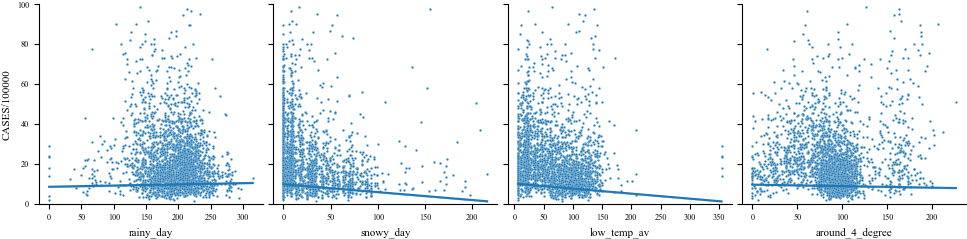

In [31]:
#weather
def linear_regression(x1,y1,weigths=None,res=100,**kwargs):
    x = np.linspace(x1.min(),x1.max(),res)
    coeff, cov = np.polyfit(x1,y1,w=weigths,deg=1,cov=True)
    cov = np.sqrt(cov)
    poly = np.poly1d(coeff)
    p = plt.gca().plot(x,poly(x),**kwargs)
    mean = np.average(x1,weights=weigths)
    plt.gca().fill_between(x,poly(x)-cov[1,1]*np.cosh(cov[0,0]*(x-mean)),poly(x)+cov[1,1]*np.cosh(cov[0,0]*(x-mean)),alpha=0.3,**kwargs)
    return


plt.figure()
graph = sns.pairplot(accidents_county,y_vars=['CASES/100000'],x_vars=['rainy_day','snowy_day','low_temp_av','around_4_degree'],plot_kws={'s':3})
graph.map_offdiag(linear_regression,weigths=accidents_county['population'])
graph.axes[0,0].set_ylim((0,100))
#plt.title('Car crashes on certain weather (countys)')
plt.show()

## List cases

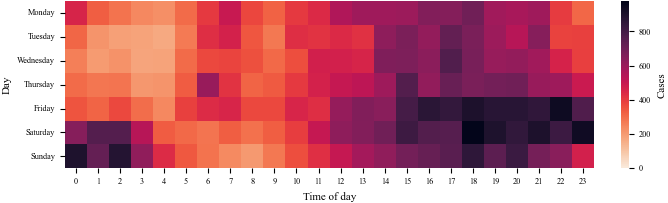

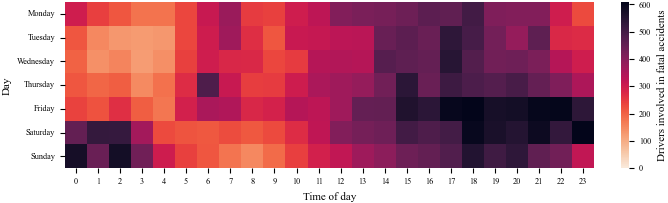

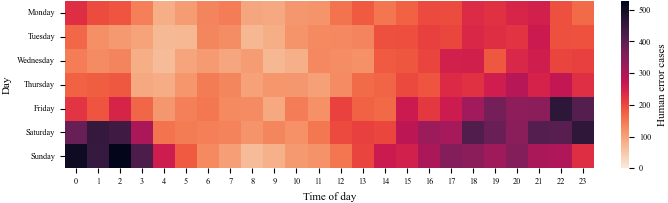

/tmp/ipykernel_5911/2839253379.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.heatmap(drivers[(drivers['HOUR']!=99) & (accidents['human_error']==1)].groupby(['DAY_WEEKNAME','HOUR']).size().unstack().loc[days,:],cbar_kws={'label':'Drivers with human error\ninvolved in fatal accident'},cmap=sns.cm.rocket_r,vmin=0)


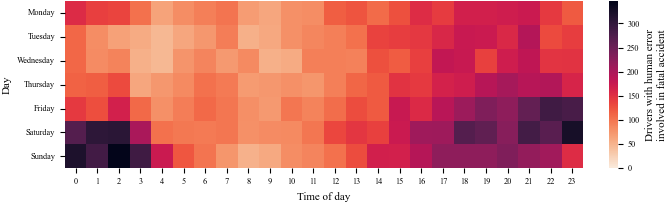

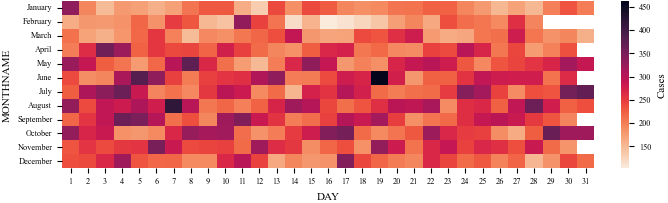

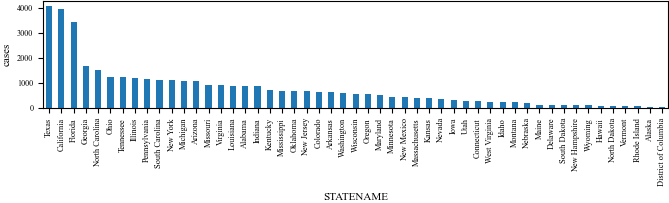

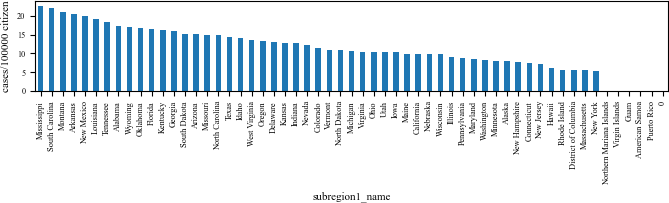

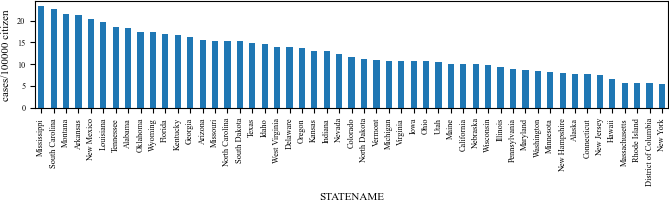

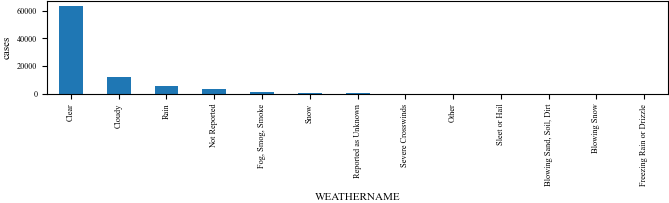

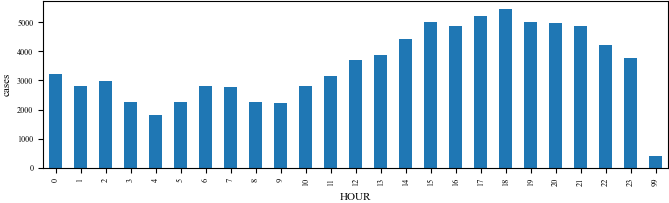

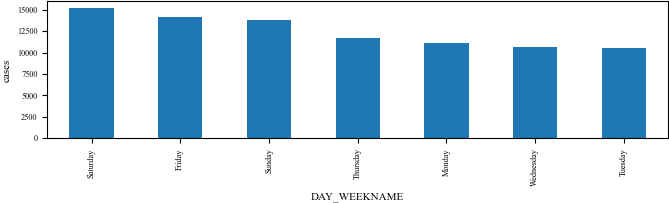

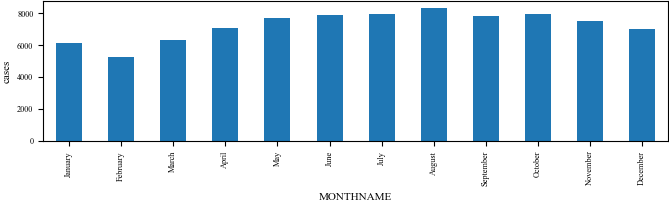

<Figure size 675x208.586 with 0 Axes>

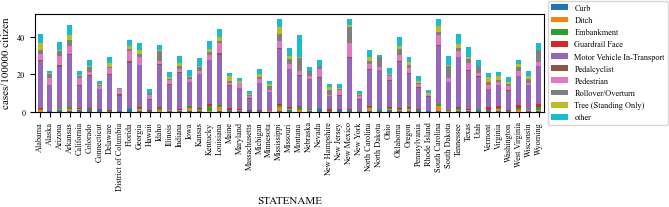

<Figure size 675x208.586 with 0 Axes>

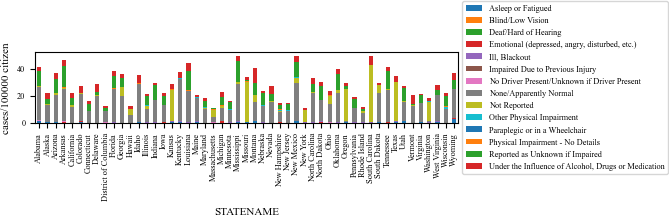

<Figure size 675x208.586 with 0 Axes>

In [72]:
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']



plt.figure()
#plt.hist2d(accidents[accidents['HOUR']!=99].groupby(['DAY_WEEKNAME','HOUR']).size())
sns.heatmap(accidents[accidents['HOUR']!=99].groupby(['DAY_WEEKNAME','HOUR']).size().unstack().loc[days,:],cbar_kws={'label':'Cases'},cmap=sns.cm.rocket_r,vmin=0)
#plt.title()
plt.ylabel('Day')
plt.xlabel('Time of day')
if save_fig == True:
    plt.savefig('plots/time plot/total_accidents-day_hour.pdf')
plt.show()

plt.figure()
#plt.hist2d(accidents[accidents['HOUR']!=99].groupby(['DAY_WEEKNAME','HOUR']).size())
sns.heatmap(drivers[drivers['HOUR']!=99].groupby(['DAY_WEEKNAME','HOUR']).size().unstack().loc[days,:],cbar_kws={'label':'Drivers involved in fatal accidents'},cmap=sns.cm.rocket_r,vmin=0)
#plt.title()
plt.ylabel('Day')
plt.xlabel('Time of day')
if save_fig == True:
    plt.savefig('plots/time plot/total_drivers-day_hour.pdf')
plt.show()


plt.figure()
#plt.hist2d(accidents[accidents['HOUR']!=99].groupby(['DAY_WEEKNAME','HOUR']).size())
sns.heatmap(accidents[(accidents['HOUR']!=99) & (accidents['human_error']==1)].groupby(['DAY_WEEKNAME','HOUR']).size().unstack().loc[days,:],cbar_kws={'label':'Human error cases'},cmap=sns.cm.rocket_r,vmin=0)
#plt.title()
plt.ylabel('Day')
plt.xlabel('Time of day')
if save_fig == True:
    plt.savefig('plots/time plot/total_accidents-day_hour-huan error.pdf')
plt.show()

plt.figure()
#plt.hist2d(accidents[accidents['HOUR']!=99].groupby(['DAY_WEEKNAME','HOUR']).size())
sns.heatmap(drivers[(drivers['HOUR']!=99) & (accidents['human_error']==1)].groupby(['DAY_WEEKNAME','HOUR']).size().unstack().loc[days,:],cbar_kws={'label':'Drivers with human error\ninvolved in fatal accident'},cmap=sns.cm.rocket_r,vmin=0)
#plt.title()
plt.ylabel('Day')
plt.xlabel('Time of day')
if save_fig == True:
    plt.savefig('plots/time plot/total_drivers-day_hour-huan error.pdf')
plt.show()


plt.figure()
sns.heatmap(accidents.groupby(['MONTHNAME','DAY']).size().unstack().loc[months,:],cbar_kws={'label':'Cases'},cmap=sns.cm.rocket_r)
if save_fig == True:
    plt.savefig('plots/time plot/total_accidents-month_day.pdf')
plt.show()

plt.figure()
accidents.groupby('ST_CASE').first()['STATENAME'].value_counts().plot.bar()
plt.ylabel('cases')
plt.show()

plt.figure()
Google_daten.groupby(by=['subregion1_name','date']).first().groupby('subregion1_name')['CASES/100000'].sum().sort_values(ascending=False).plot(kind='bar')
#Google_daten.groupby('subregion1_name')['mobility_workspaces'].first().plot(kind='bar')
plt.ylabel('cases/100000 citizen')
plt.show()


plt.figure()
#plt.title('cases per 100000 habitants')
accidents_state.set_index('STATENAME')['CASES/100000'].sort_values(ascending=False).plot.bar()
plt.ylabel('cases/100000 citizen')
if save_fig == True:
    plt.savefig('plots/time plot/total_accidents_100000-state.pdf')
plt.show()

plt.figure()
accidents['WEATHERNAME'].value_counts().plot.bar()
plt.ylabel('cases')
plt.show()

plt.figure()
accidents['HOUR'].value_counts().sort_index().plot.bar()
plt.ylabel('cases')
plt.show()

plt.figure()
accidents['DAY_WEEKNAME'].value_counts().plot.bar()
plt.ylabel('cases')
plt.show()

plt.figure()
accidents['MONTHNAME'].value_counts()[months].plot.bar()
plt.ylabel('cases')
plt.show()


accidents['HARM_EVNAME'] = accidents['HARM_EVNAME'].replace(accidents['HARM_EVNAME'].value_counts().index[10:],'other')
accidents['DRIVERRFNAME'] = accidents['DRIVERRFNAME'].replace(accidents['DRIVERRFNAME'].value_counts().index[10:],'other').fillna('None')
#labels_driverrf = [ '\n'.join(wrap(l, 20)) for l in accidents['DRIVERRFNAME'].unique()]

plt.figure()
accidents.groupby(['STATENAME','HARM_EVNAME']).size().unstack().div(accidents_state.set_index('STATENAME')['population']/100000,axis=0).plot(kind='bar',stacked=True)
plt.ylabel('cases/100000 citizen')
#plt.title('harmed environment')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure()
accidents.groupby(['STATENAME','DRIMPAIRNAME']).size().unstack().div(accidents_state.set_index('STATENAME')['population']/100000,axis=0).plot(kind='bar',stacked=True)
plt.ylabel('cases/100000 citizen')
#plt.title('Drimpair')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


plt.figure()
accidents.groupby(['STATENAME','DRIVERRFNAME']).size().unstack().div(accidents_state.set_index('STATENAME')['population']/100000,axis=0).plot(kind='bar',stacked=True)
plt.ylabel('cases/100000 citizen')
#plt.title('driverrf')
#plt.legend(labels_driverrf,loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure()
accidents.groupby(['STATENAME','WEATHERNAME']).size().unstack().div(accidents_state.set_index('STATENAME')['population']/100000,axis=0).plot(kind='bar',stacked=True)
plt.ylabel('cases/100000 citizen')
#plt.title('weather at accident')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Geo Plot


[-1  0  1  2]


<Figure size 675x208.586 with 0 Axes>

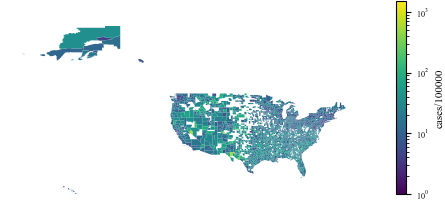

<Figure size 675x208.586 with 0 Axes>

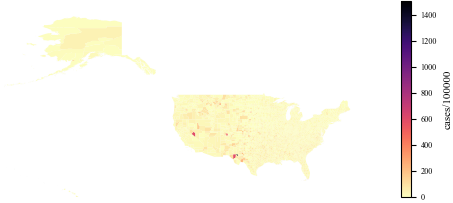

<Figure size 675x208.586 with 0 Axes>

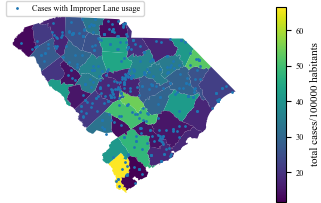

<Figure size 675x208.586 with 0 Axes>

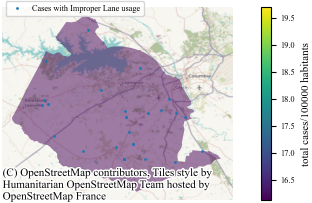

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


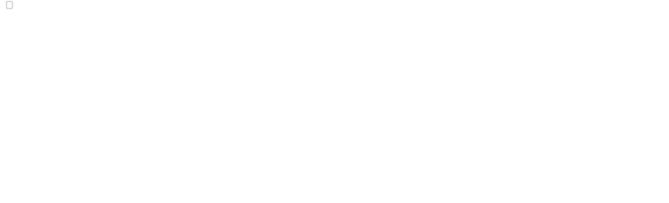

/tmp/ipykernel_5911/4257994436.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.scatter(x=accidents[accidents['STATENAME']=='Idaho'][accidents['DRIVERRFNAME']=='Improper Lane Usage']['LONGITUD'],y=accidents[accidents['STATENAME']=='Idaho'][accidents['DRIVERRFNAME']=='Improper Lane Usage']['LATITUDE'],s=1,label='cases with Improper Lane usage')
/tmp/ipykernel_5911/4257994436.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.scatter(x=accidents[accidents['STATENAME']=='Idaho'][accidents['DRIVERRFNAME']=='Improper Lane Usage']['LONGITUD'],y=accidents[accidents['STATENAME']=='Idaho'][accidents['DRIVERRFNAME']=='Improper Lane Usage']['LATITUDE'],s=1,label='cases with Improper Lane usage')


<Figure size 675x208.586 with 0 Axes>

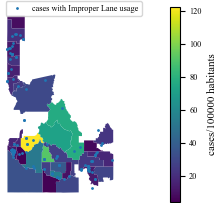

<Figure size 675x208.586 with 0 Axes>

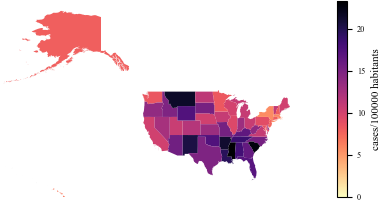

<Figure size 675x208.586 with 0 Axes>

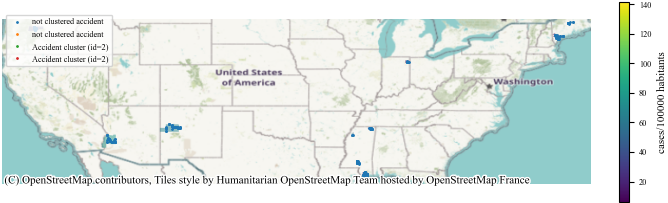

In [33]:
#following clusters could be used:
print(accidents['cluster'].unique())



states_improper_lane = accidents_county.sort_values('Improper Lane Usage',ascending=False)['STATENAME'].unique()[:1]
county_improper_lane = accidents_county.sort_values('Improper Lane Usage',ascending=False)['COUNTYNAME'].unique()[:1]

plt.figure()
US_county_shape.plot(column='CASES/100000',legend=True,legend_kwds={'label':'cases/100000'},norm=matplotlib.colors.LogNorm(vmin=1, vmax=US_county_shape['CASES/100000'].max()))
plt.xlim(-180,-60)
plt.ylim(20,None)
plt.axis('off')
plt.show()

plt.figure()
US_county_shape.plot(column='CASES/100000',legend=True,legend_kwds={'label':'cases/100000'},cmap='magma_r')
plt.xlim(-180,-60)
plt.ylim(20,None)
plt.axis('off')
plt.show()

for state in states_improper_lane:
    plt.figure()
    ax = US_county_shape[US_county_shape['STATENAME'] == state].plot(column='CASES/100000',legend=True,legend_kwds={'label':'total cases/100000 habitants'})
    plt.xlim(plt.gca().get_xlim())
    plt.ylim(plt.gca().get_ylim())
    ax.scatter(x=accidents[(accidents['STATENAME']==state) & (accidents['DRIVERRFNAME']=='Improper Lane Usage')]['LONGITUD'],y=accidents[(accidents['STATENAME']==state) & (accidents['DRIVERRFNAME']=='Improper Lane Usage')]['LATITUDE'],s=1,label='Cases with Improper Lane usage')
    plt.axis('off')
    #plt.title(state)
    plt.legend(loc='upper left',bbox_to_anchor=(0, 1.05))
    plt.show()

#US_county_shape = US_county_shape.to_crs(3857)
for county in county_improper_lane:
    plt.figure()
    ax = US_county_shape[US_county_shape['COUNTYNAME'] == county].plot(column='CASES/100000',legend=True,legend_kwds={'label':'total cases/100000 habitants'},alpha=0.5)
    plt.xlim(plt.gca().get_xlim())
    plt.ylim(plt.gca().get_ylim())
    ax.scatter(x=accidents[(accidents['COUNTYNAME']==county) & (accidents['DRIVERRFNAME']=='Improper Lane Usage')]['LONGITUD'],y=accidents[(accidents['COUNTYNAME']==county) & (accidents['DRIVERRFNAME']=='Improper Lane Usage')]['LATITUDE'],s=1,label='Cases with Improper Lane usage')
    cx.add_basemap(ax,crs=US_county_shape.crs)
    plt.axis('off')
    #plt.title(county)
    plt.legend(loc='upper left',bbox_to_anchor=(0, 1.05))
    plt.show()

   
cx.add_basemap(ax,crs=US_county_shape.crs)
plt.axis('off')
#plt.title('Plot of cluster')
plt.legend(loc='upper left',bbox_to_anchor=(0, 1.05))
plt.show()


plt.figure()
ax = US_county_shape[US_county_shape['STATENAME'] == 'Idaho'].plot(column='CASES/100000',legend=True,legend_kwds={'label':'cases/100000 habitants'})
ax.scatter(x=accidents[accidents['STATENAME']=='Idaho'][accidents['DRIVERRFNAME']=='Improper Lane Usage']['LONGITUD'],y=accidents[accidents['STATENAME']=='Idaho'][accidents['DRIVERRFNAME']=='Improper Lane Usage']['LATITUDE'],s=1,label='cases with Improper Lane usage')
plt.axis('off')
#plt.title('Idaho')
plt.legend(loc='upper left',bbox_to_anchor=(0, 1.05))
plt.show()

plt.figure()
US_state_shape.plot(column='CASES/100000',legend=True,legend_kwds={'label':'cases/100000 habitants'},cmap='magma_r',vmin=0)
plt.xlim(-180,-60)
plt.ylim(20,None)
plt.axis('off')
if save_fig == True:
    plt.savefig('plots/geo plot/total_accidents_100000-state.pdf')
plt.show()


def plt_cluster(cluster_id,whole_state=True,color_cluster=True):
    if cluster_id not in accidents['cluster'].unique():
        raise Exception('cluster does not exist, please use a cluster in '+str(accidents['cluster'].unique()))
    plt.figure()
    if whole_state == True:
        code = accidents[accidents['cluster']==cluster_id]['subregion2_code'].unique()
        ax = US_county_shape[US_county_shape['subregion2_code'].isin(code)].plot(column='CASES/100000',legend=True,legend_kwds={'label':'cases/100000 habitants'},alpha=0.5)
        plt.xlim(plt.gca().get_xlim())
        plt.ylim(plt.gca().get_ylim())
        if color_cluster==True:
            for i in accidents[accidents['subregion2_code'].isin(code)]['cluster'].unique():
                if i == -1:
                    label = 'not clustered accident'
                elif i == cluster_id:
                    label = 'Accident cluster (id='+str(i)+')'
                ax.scatter(x=accidents[(accidents['subregion2_code'].isin(code)) & (accidents['cluster']==i)]['LONGITUD'],y=accidents[(accidents['subregion2_code'].isin(code)) & (accidents['cluster']==i)]['LATITUDE'],s=1,label=label)
        else:
            ax.scatter(x=accidents[(accidents['subregion2_code'].isin(code)) & (accidents['cluster']==-1)]['LONGITUD'],y=accidents[(accidents['subregion2_code'].isin(code)) & (accidents['cluster']==-1)]['LATITUDE'],s=1,label='accidents')
            ax.scatter(x=accidents[(accidents['subregion2_code'].isin(code)) & (accidents['cluster']==cluster_id)]['LONGITUD'],y=accidents[(accidents['subregion2_code'].isin(code)) & (accidents['cluster']==cluster_id)]['LATITUDE'],s=1,label='cluster (id='+str(cluster_id)+')')
    else:
        latitude_min = accidents[accidents['cluster']==cluster_id]['LATITUDE'].min()
        latitude_max = accidents[accidents['cluster']==cluster_id]['LATITUDE'].max()
        longitud_min = accidents[accidents['cluster']==cluster_id]['LONGITUD'].min()
        longitud_max = accidents[accidents['cluster']==cluster_id]['LONGITUD'].max()
        epsilon = 1e-4
        temp = accidents[(accidents['LATITUDE']>latitude_min-epsilon) & (accidents['LATITUDE']<latitude_max+epsilon) & (accidents['LONGITUD']>longitud_min-epsilon) & (accidents['LONGITUD']<longitud_max+epsilon)]
        fig, ax = plt.subplots()
        ax.scatter(x=temp[temp['cluster']==cluster_id]['LONGITUD'],y=temp[temp['cluster']==cluster_id]['LATITUDE'],s=1,label='cluster (id='+str(cluster_id)+')')
        plt.xlim(plt.gca().get_xlim())
        plt.ylim(plt.gca().get_ylim())
        if color_cluster==True:
            for i in temp[temp['cluster']!=cluster_id]['cluster'].unique():
                if i == -1:
                    label = 'not clustered accident'
                else:
                    label = 'Accident cluster (id='+str(i)+')'
                ax.scatter(x=temp[temp['cluster']==i]['LONGITUD'],y=temp[temp['cluster']==i]['LATITUDE'],s=1,label=label)
        else:
            ax.scatter(x=temp[temp['cluster']!=cluster_id]['LONGITUD'],y=temp[temp['cluster']!=cluster_id]['LATITUDE'],s=1,label='accidents')
    cx.add_basemap(ax,crs=US_county_shape.crs)
    plt.axis('off')
    plt.legend(loc='upper left',bbox_to_anchor=(0, 1.05))
    return
#cluster_id = 32
plt_cluster(2,True)



Human error plots 


Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry', 'STATENAME', 'STATE', 'CASES',
       'human_error', 'population', 'population_density', 'area', 'latitude',
       'longitude', 'population_age_00_09', 'population_age_10_19',
       'population_age_20_29', 'population_age_30_39', 'population_age_40_49',
       'population_age_50_59', 'population_age_60_69', 'population_age_70_79',
       'population_age_80_89', 'population_age_90_99',
       'population_age_80_and_older', 'population_prop_age_00_09',
       'population_prop_age_10_19', 'population_prop_age_20_29',
       'population_prop_age_30_39', 'population_prop_age_40_49',
       'population_prop_age_50_59', 'population_prop_age_60_69',
       'population_prop_age_70_79', 'population_prop_age_80_89',
       'population_prop_age_90_99', 'population_prop_age_80_and_older',
       'rainy_day', 'snowy_day', 'low_temp_av', 'low_temp_min', 'low_temp_max',
       'around_4_

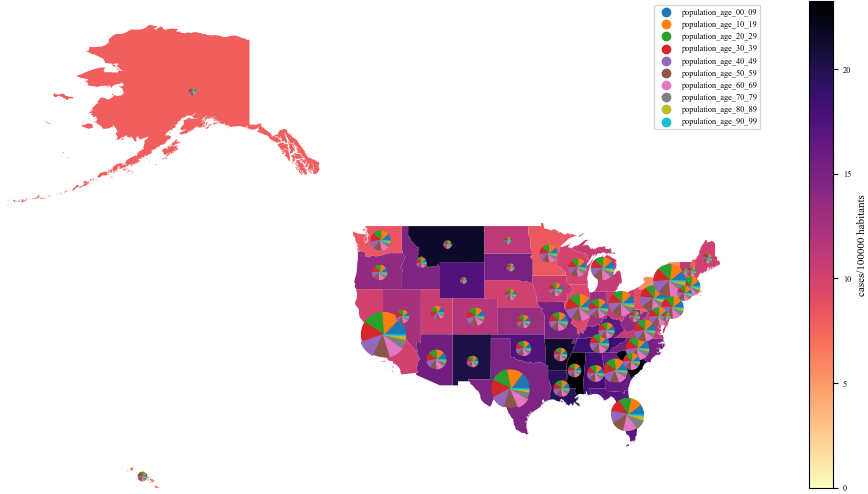

In [10]:
# pie chart geoplot
print(US_state_shape.columns)

def drawPieMarker(xs, ys, ratios_list, sizes, colors):
    ratios_list = ratios_list/ratios_list.sum(axis=0)
    
    
    for i in range(len(ratios_list.iloc[:,0])):
        markers = []
        previous = 0
        # calculate the points of the pie pieces
        for color, ratio in zip(colors, ratios_list):
            #print(ratios)
            this = 2 * np.pi * ratio + previous
            x  = [0] + np.cos(np.linspace(previous, this, 10)).tolist() + [0]
            y  = [0] + np.sin(np.linspace(previous, this, 10)).tolist() + [0]
            xy = np.column_stack([x, y])
            previous = this
            markers.append({'marker':xy, 's':np.abs(xy).max()**2*np.array(sizes), 'facecolor':color})

        # scatter each of the pie pieces to create pies
        for marker in markers:
            ax.scatter(xs, ys, **marker)

def draw_pie(dist, xpos, ypos, size, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,8))

    # for incremental pie slices
    cumsum = np.cumsum(dist)
    cumsum = cumsum/ cumsum[-1]
    pie = [0] + cumsum.tolist()

    for r1, r2 in zip(pie[:-1], pie[1:]):
        angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2)
        x = [0] + np.cos(angles).tolist()
        y = [0] + np.sin(angles).tolist()

        xy = np.column_stack([x, y])

        ax.scatter([xpos], [ypos], marker=xy, s=size)
    return ax


#print(US_county_shape.loc[0,'geometry'])

fig, ax = plt.subplots(1,1,figsize=(10,5))
US_state_shape.plot(ax=ax,column='CASES/100000',legend=True,legend_kwds={'label':'cases/100000 habitants'},cmap='magma_r',vmin=0)#,subplots=True)
#drawPieMarker(xs=US_state_shape['longitude'],ys=US_state_shape['latitude'],ratios_list=US_state_shape[['population_age_00_09','population_age_10_19']],sizes=US_state_shape['CASES/100000'],colors=[rgb.tue_red,rgb.tue_green])
for i in range(len(US_state_shape.iloc[:,0])):
    draw_pie(US_state_shape.loc[i,'population_age_00_09':'population_age_90_99'],xpos=US_state_shape.loc[i,'longitude'],ypos=US_state_shape.loc[i,'latitude'],
             size=US_state_shape.loc[i,'population']/US_state_shape['population'].max()*1e3,ax=ax)
for i in US_state_shape.loc[:,'population_age_00_09':'population_age_90_99'].columns:
    plt.scatter(np.nan,np.nan,label=i)
#US_state_shape.plot(kind='pie',column='CASES/100000',y=1)
plt.legend()
#plt.scatter(US_state_shape['longitude'],US_state_shape['latitude'],s=2)
plt.xlim(-180,-60)
plt.ylim(20,None)
plt.axis('off')
plt.show()

AGE
6       1
9       3
10      3
11      6
12     11
       ..
94      3
96      1
98      2
998    98
999    98
Name: count, Length: 91, dtype: int64
0.0      NaN
1.0      0.0
2.0      0.0
3.0      0.0
4.0      0.0
        ... 
96.0     1.0
97.0     1.0
98.0     2.0
99.0     2.0
100.0    0.0
Length: 101, dtype: float64
L_TYPE
0    37
7     4
9     6
Name: count, dtype: int64
   L_TYPE                                   L_TYPENAME  count
0       0                                 Not Licensed   6735
1       1                          Full Driver License  74749
2       2                  Intermediate Driver License   1571
3       6  No Driver Present/Unknown if Driver Present    111
4       7                             Learner's Permit    837
5       8                            Temporary License     98
6       9                         Unknown License Type   3043
None


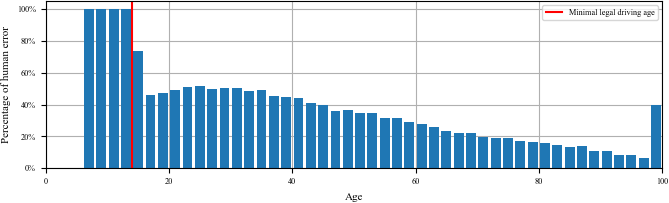

0.0     NaN
1.0     NaN
2.0     NaN
3.0     NaN
4.0     NaN
5.0     NaN
6.0     1.0
7.0     1.0
8.0     NaN
9.0     1.0
10.0    1.0
11.0    1.0
12.0    1.0
13.0    1.0
dtype: float64


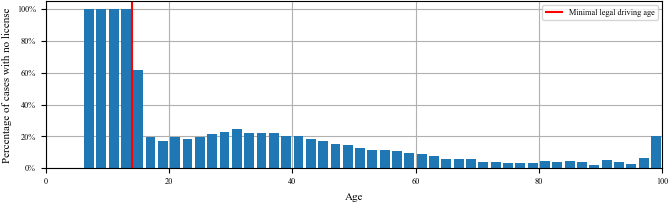

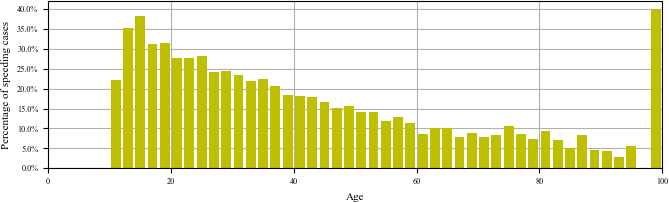

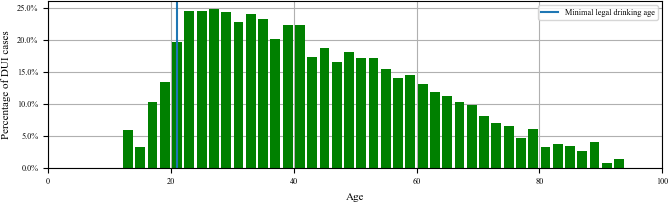

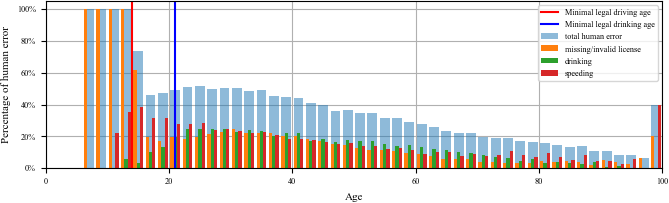

4034
5955
5955


In [35]:

# change bin size
bins = 2
# chooses bin offset to have no overlapp with ages <14 and >14
offset = 13 % bins


### plot with age 
length = 101

empty_series = pd.Series(index=np.arange(length),data=np.zeros(length))
human_error_counts = (empty_series + drivers[drivers['human_error']==1].value_counts('AGE',sort=False)).fillna(0).iloc[:length].rolling(bins).sum().set_axis(empty_series.keys()-bins/2+1)
total_counts = (empty_series + drivers.value_counts('AGE',sort=False)).fillna(0).iloc[:length].rolling(bins).sum().set_axis(empty_series.keys()-bins/2+1)

print(drivers[drivers['human_error']==1].value_counts('AGE',sort=False))
print(human_error_counts)

#total_counts = total_counts.replace(0,1) ### Avoid dividing by 0. Numerator will be 0 anyway.
#total_counts[0] = 1
quot = human_error_counts / total_counts
#quot = [human_error_counts[i] /total_counts[i] for i in range(len(total_counts))]


print(drivers[drivers['AGE']==14].value_counts('L_TYPE',sort=False))
print(explain('L_TYPE'))

ax = plt.subplot()
ax.bar((quot.iloc[offset::bins]).keys(),quot.iloc[offset::bins].values*100,width=0.8*bins)
ax.yaxis.set_major_formatter(tck.PercentFormatter())
plt.xlim(0,100)
#plt.title('Human error percentage by age')
plt.xlabel('Age')
plt.ylabel('Percentage of human error')
plt.axvline(x=14, color='r', linestyle='-',label='Minimal legal driving age')
plt.legend()
ax.set_axisbelow(True)
plt.grid(which='major')
if save_fig == True:
    plt.savefig('plots/human error/human_error-age.pdf')
plt.show()

### Print calculated arrays as sanity check
print(quot.head(14)) ##thats great news, at 14 you can legally get your license in some states. Under 14, everything is classified as human error.

### Portion of revoked license 

license_counts = (empty_series + drivers[(drivers['L_TYPE']==0) | (drivers['L_STATUS'].isin([0,1,2,3,4,7]))].value_counts('AGE',sort=False)).fillna(0).iloc[:length].rolling(bins).sum().set_axis(empty_series.keys()-bins/2+1)
quot_license = license_counts/total_counts

ax = plt.subplot()
ax.bar(quot_license.iloc[offset::bins].keys(),quot_license.iloc[offset::bins].values*100,width=0.8*bins)
ax.yaxis.set_major_formatter(tck.PercentFormatter())
plt.xlim(0,100)
#plt.title('No license percentage by age')
plt.xlabel('Age')
plt.ylabel('Percentage of cases with no license')
plt.axvline(x=14, color='r', linestyle='-',label='Minimal legal driving age')
plt.legend()
ax.set_axisbelow(True)
plt.grid(which='major')
if save_fig == True:
    plt.savefig('plots/human error/license-age.pdf')
plt.show()

###Speeding 

speeding_counts = (empty_series + drivers[drivers['SPEEDREL'].isin([2,3,4,5,8])].value_counts('AGE',sort=False)).fillna(0).iloc[:length].rolling(bins).sum().set_axis(empty_series.keys()-bins/2+1)
quot_speeding = speeding_counts/total_counts

ax = plt.subplot()
ax.bar(quot_speeding.iloc[offset::bins].keys(),quot_speeding.iloc[offset::bins].values*100,color='y',width=0.8*bins)
ax.yaxis.set_major_formatter(tck.PercentFormatter())
plt.xlim(0,100)
#plt.title('Speeding percentage by age')
plt.xlabel('Age')
plt.ylabel('Percentage of speeding cases')
ax.set_axisbelow(True)
plt.grid(which='major')
if save_fig == True:
    plt.savefig('plots/human error/speeding-age.pdf')
plt.show()

### Alcohol

alcohol_counts = (empty_series + drivers[drivers["DR_DRINK"]==1].value_counts('AGE',sort=False)).fillna(0).iloc[:length].rolling(bins).sum().set_axis(empty_series.keys()-bins/2+1)
quot_alcohol = alcohol_counts/total_counts

ax = plt.subplot()
ax.bar(quot_alcohol.iloc[offset::bins].keys(),quot_alcohol.iloc[offset::bins].values*100,color='g',width=0.8*bins)
ax.yaxis.set_major_formatter(tck.PercentFormatter())
plt.xlim(0,100)
#plt.title('DUI percentage by age')
plt.axvline(x=21,label='Minimal legal drinking age')
plt.xlabel('Age')
plt.ylabel('Percentage of DUI cases')
plt.legend()
ax.set_axisbelow(True)
plt.grid(which='major')
if save_fig == True:
    plt.savefig('plots/human error/drinking-age.pdf')
plt.show()

#multiplot 
width = 0.8/3*bins
ax = plt.subplot()
ax.bar(quot.iloc[offset::bins].keys(),quot.iloc[offset::bins].values*100,alpha=0.5,label='total human error',width=0.8*bins)
ax.bar(quot_license.iloc[offset::bins].keys()-width,quot_license.iloc[offset::bins].values*100,width=width,label='missing/invalid license')
ax.bar(quot_alcohol.iloc[offset::bins].keys(),quot_alcohol.iloc[offset::bins].values*100,width=width,label='drinking')
ax.bar(quot_speeding.iloc[offset::bins].keys()+width,quot_speeding.iloc[offset::bins].values*100,width=width,label='speeding')
ax.yaxis.set_major_formatter(tck.PercentFormatter())
plt.xlim(0,100)
#plt.title('different human errors')
plt.xlabel('Age')
plt.ylabel('Percentage of human error')
plt.axvline(x=14, color='r', linestyle='-',label='Minimal legal driving age')
plt.axvline(x=21, color='b',label='Minimal legal drinking age')
plt.legend()
ax.set_axisbelow(True)
plt.grid(which='major')
if save_fig == True:
    plt.savefig('plots/human error/human_error_multiplot-age.pdf')
plt.show()

### Check for duplicate causes

print(len(drivers[(drivers['DR_DRINK'] == 1) & (drivers['SPEEDREL'].isin([2,3,4,5,8]))]))
print(len(drivers[(drivers['L_TYPE']==0) | (drivers['L_STATUS'].isin([0,1,2,3,4,7,9])) & (drivers['SPEEDREL'].isin([2,3,4,5,8]))]))
print(len(drivers[(drivers['L_TYPE']==0) | (drivers['L_STATUS'].isin([0,1,2,3,4,7,9])) & (drivers['SPEEDREL'].isin([2,3,4,5,8]))]))



0.0      NaN
1.0      0.0
2.0      0.0
3.0      0.0
4.0      0.0
        ... 
96.0     1.0
97.0     1.0
98.0     2.0
99.0     2.0
100.0    0.0
Length: 101, dtype: float64
<class 'pandas.core.series.Series'>


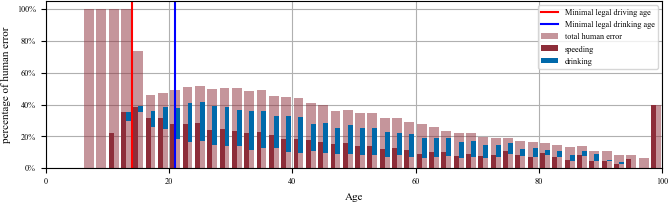

In [36]:

## Stacking plot
# How to read the plot:
# overlapping means multiple human errors
bins = 2
# chooses bin offset to have no overlapp with ages <14 and >14
offset = 13 % bins
length= 101

empty_series = pd.Series(index=np.arange(length),data=np.zeros(length))
human_error_counts = (empty_series + drivers[drivers['human_error']==1].value_counts('AGE',sort=False)).fillna(0).iloc[:length].rolling(bins).sum().set_axis(empty_series.keys()-bins/2+1)
total_counts = (empty_series + drivers.value_counts('AGE',sort=False)).fillna(0).iloc[:length].rolling(bins).sum().set_axis(empty_series.keys()-bins/2+1)
quot = human_error_counts/total_counts
print(human_error_counts)
print(type(human_error_counts))

speeding_counts = (empty_series + drivers[drivers['SPEEDREL'].isin([2,3,4,5,8])].value_counts('AGE',sort=False)).fillna(0).iloc[:length].rolling(bins).sum().set_axis(empty_series.keys()-bins/2+1)
quot_speeding = speeding_counts/total_counts

alcohol_counts = (empty_series + drivers[drivers["DR_DRINK"]==1].value_counts('AGE',sort=False)).fillna(0).iloc[:-2].rolling(bins).sum().set_axis(empty_series.keys()-bins/2+1)
quot_alcohol = alcohol_counts/total_counts

speeding_without_alcohol_counts = (empty_series + drivers[(drivers['SPEEDREL'].isin([2,3,4,5,8])) & (drivers["DR_DRINK"]!=1)].value_counts('AGE',sort=False)).fillna(0).iloc[:length].rolling(bins).sum().set_axis(empty_series.keys()-bins/2+1)
quot_speeding_without_alcohol = speeding_without_alcohol_counts/total_counts

#print(quot.keys().rolling(2).mean())

width = 0.4*bins
ax = plt.subplot()
ax.bar(quot.iloc[offset::bins].keys(),quot.iloc[offset::bins].values*100,alpha=0.5,label='total human error',width=0.8*bins,color=rgb.tue_red)
ax.bar(quot_speeding.iloc[offset::bins].keys()-width/2,quot_speeding.iloc[offset::bins].values*100,width=width,label='speeding',color=rgb.tue_red)
ax.bar(quot_alcohol.iloc[offset::bins].keys()+width/2,quot_alcohol.iloc[offset::bins].values*100,bottom=quot_speeding_without_alcohol.iloc[offset::bins].values*100,width=width,label='drinking',color=rgb.tue_blue)
ax.yaxis.set_major_formatter(tck.PercentFormatter())
plt.xlim(0,100)
#plt.title('percentage by age')
plt.xlabel('Age')
plt.ylabel('percentage of human error')
plt.axvline(x=14, color='r', linestyle='-',label='Minimal legal driving age')
plt.axvline(x=21, color='b',label='Minimal legal drinking age')
plt.legend()
ax.set_axisbelow(True)
plt.grid(which='major')
if save_fig == True:
    plt.savefig('plots/human error/human_error_drinking_speeding-age.pdf')
plt.show()

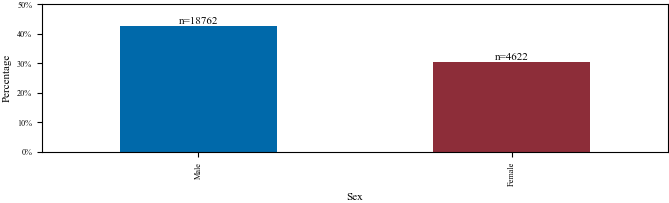

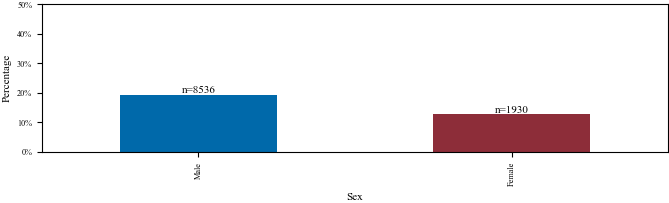

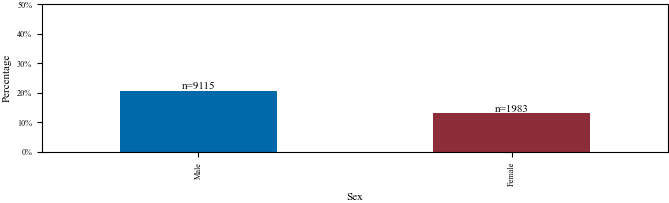

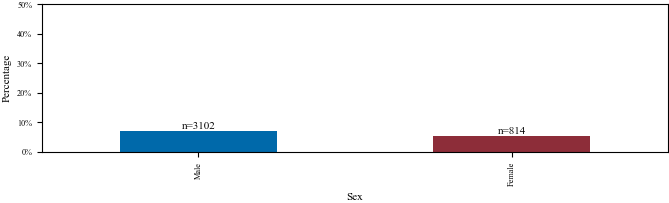

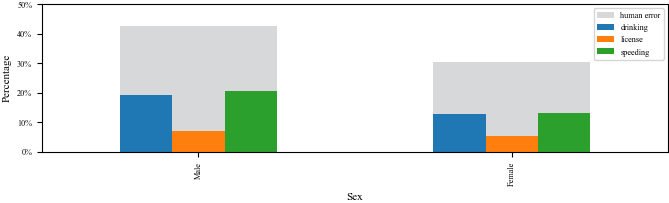

Cond. Prob. of Road rage if being drunk: 0.007155123068116772
Cond Pron. of beinG drunk if road rage is true 0.3456221198156682


Text(0, 0.5, 'Recorded Cases')

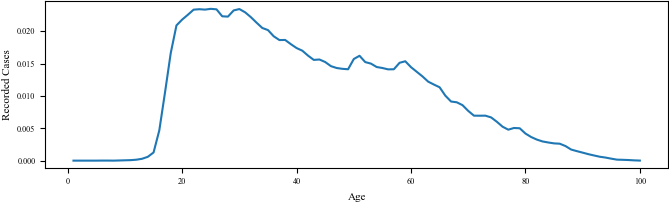

In [37]:
### Try to plot other interesting categories

## Some ideas (some from the group): Human error by sex
##(maybe we shouldnt include it in the report though)
## correlation between drunk driving and road rage etc. 

counts_total = drivers[drivers['human_error']==1].value_counts('SEXNAME').rename('human error')
counts_norm = (drivers[drivers['human_error']==1].value_counts('SEXNAME')/drivers.value_counts('SEXNAME')*100).rename('human error')
# adjust graph if needed
used_gender = ['Male','Female']#,'Reported as Unknown','Not Reported']
gender_colors = [rgb.tue_blue,rgb.tue_red]


ax = plt.subplot()
counts_norm[used_gender].plot(kind='bar',ax=ax,color=gender_colors)
#ax.bar(x_bins,vals,label='total human error',width=0.4)
ax.yaxis.set_major_formatter(tck.PercentFormatter())
plt.xlabel('Sex')
plt.ylabel('Percentage')
#plt.title('Human error by sex')
plt.ylim(0,50)
#plt.legend()
for gender in used_gender:
    plt.text(counts_norm[used_gender].index.to_list().index(gender),counts_norm[used_gender][gender], 'n='+str(counts_total[gender]),
             horizontalalignment='center',
             verticalalignment='bottom')
if save_fig == True:
    plt.savefig('plots/human error/human error-gender.pdf')
plt.show()


### If interesting we can make a stacked plot 
### Plots only have to be made nice if we decide to use them

### Cond prob of drunk drive by sex:
counts_drunk = drivers[drivers['DR_DRINK']==1].value_counts('SEXNAME').rename('drinking')
counts_drunk_norm = (drivers[drivers['DR_DRINK']==1].value_counts('SEXNAME')/drivers.value_counts('SEXNAME')*100).rename('drinking')

ax = plt.subplot()
counts_drunk_norm[used_gender].plot(kind='bar',ax=ax,color=gender_colors)
ax.yaxis.set_major_formatter(tck.PercentFormatter())
plt.xlabel('Sex')
plt.ylabel('Percentage')
#plt.title('Drunk driving by sex')
plt.ylim(0,50)
#plt.legend()
for gender in used_gender:
    plt.text(counts_drunk_norm[used_gender].index.to_list().index(gender),counts_drunk_norm[used_gender][gender], 'n='+str(counts_drunk[gender]),
             horizontalalignment='center',
             verticalalignment='bottom')
if save_fig == True:
    plt.savefig('plots/human error/drinking-gender.pdf')
plt.show()

### Speeding

counts_speeding = (drivers[drivers['SPEEDREL'].isin([2,3,4,5,8])].value_counts('SEXNAME')).rename('speeding')
counts_speeding_norm = (drivers[drivers['SPEEDREL'].isin([2,3,4,5,8])].value_counts('SEXNAME')/drivers.value_counts('SEXNAME')*100).rename('speeding')
## the label n is the total amount in the respective category


ax = plt.subplot()
counts_speeding_norm[used_gender].plot(kind='bar', ax=ax,color=gender_colors)
ax.yaxis.set_major_formatter(tck.PercentFormatter())
plt.xlabel('Sex')
plt.ylabel('Percentage')
#plt.title('Speeding by sex')
plt.ylim(0,50)
#plt.legend()
for gender in used_gender:
    plt.text(counts_speeding_norm[used_gender].index.to_list().index(gender),counts_speeding_norm[used_gender][gender], 'n='+str(counts_speeding[gender]),
             horizontalalignment='center',
             verticalalignment='bottom')
if save_fig == True:
    plt.savefig('plots/human error/speeding-gender.pdf')
plt.show()

### License problems

counts_license = (drivers[drivers['L_TYPE']==0].value_counts('SEXNAME')).rename('license')
counts_license_norm = (drivers[drivers['L_TYPE']==0].value_counts('SEXNAME')/drivers.value_counts('SEXNAME')*100).rename('license')
## the label n is the total amount in the respective category

ax = plt.subplot()
counts_license_norm[used_gender].plot(kind='bar', ax=ax,color=gender_colors)
ax.yaxis.set_major_formatter(tck.PercentFormatter())
plt.xlabel('Sex')
plt.ylabel('Percentage')
#plt.title('License error  by sex')
plt.ylim(0,50)
#plt.legend()
for gender in used_gender:
    plt.text(counts_license_norm[used_gender].index.to_list().index(gender),counts_license_norm[used_gender][gender], 'n='+str(counts_license[gender]),
             horizontalalignment='center',
             verticalalignment='bottom')
if save_fig == True:
    plt.savefig('plots/human error/license-gender.pdf')
plt.show()

# multiplot gender
ax = plt.subplot()
counts_norm[used_gender].plot(kind='bar', ax=ax, alpha=0.5,color=rgb.tue_gray)
pd.concat([counts_drunk_norm,counts_license_norm,counts_speeding_norm],axis=1).loc[used_gender].plot(kind='bar',ax=ax)
ax.yaxis.set_major_formatter(tck.PercentFormatter())
plt.xlabel('Sex')
plt.ylabel('Percentage')
#plt.title('License error  by sex')
plt.ylim(0,50)
plt.legend()
if save_fig == True:
    plt.savefig('plots/human error/human_error_multiplot-gender.pdf')
plt.show()



### Look at conditional probabilites from DRIVERRF
drunk_rage = len(drivers[(drivers['DRIVERRF']==8) & (drivers['DR_DRINK']==1)])
drunk = len(drivers[drivers['DR_DRINK']==1])
rage = len(drivers[drivers['DRIVERRF']==8])
print('Cond. Prob. of Road rage if being drunk:',drunk_rage / drunk)
print('Cond Pron. of beinG drunk if road rage is true', drunk_rage / rage) ## If your are raod raging you are more likely to be drunk


### Ideas: Time and alcohol (expect more at night ), make most likely cause by state plot


### Age comparsion deadly accidents (only drivers) vs. us population
### If interesting would have to use the census dataset (altough age only available in 5 year bins)

bins=2
empty_series = pd.Series(index=np.arange(101),data=np.zeros(101))
total_counts = (empty_series + drivers.value_counts('AGE',sort=False)).fillna(0).iloc[:length].rolling(bins,center=True).sum()
vals = total_counts.values
vals_sum = sum(vals[1:])
plt.plot(vals / vals_sum)
plt.xlabel('Age')
plt.ylabel('Recorded Cases')
#plt.title('Age of recorded cases')





2.718281828459045
[-5.48196295e-04  5.76158105e+01]
[[7.46612026e-05            nan]
 [           nan 1.93244554e-01]]


/tmp/ipykernel_5911/1455630176.py:6: RuntimeWarning: invalid value encountered in sqrt
  cov = np.sqrt(cov)


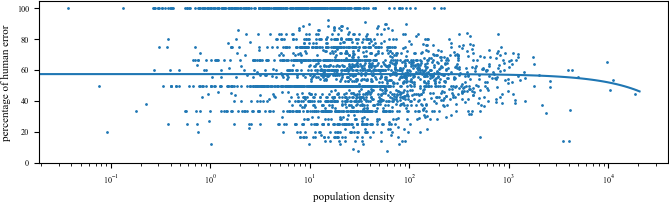

COUNTYNAME
BERNALILLO (1)              306
ADAMS (1)                   224
ALAMEDA (1)                 150
ALACHUA (1)                 122
DISTRICT OF COLUMBIA (1)     89
KENT (1)                     78
ATLANTIC (1)                 72
ANDERSON (1)                 70
FAIRFIELD (1)                67
ACADIA (1)                   66
HAWAII (1)                   61
ADA (1)                      48
ALBANY (1)                   46
ADAIR (1)                    44
BARNSTABLE (1)               43
APACHE (1)                   36
AUTAUGA (1)                  34
ALAMANCE (1)                 30
ALLEGANY (1)                 20
ANDROSCOGGIN (1)             18
BAKER (1)                    14
ACCOMACK (1)                 13
CHURCHILL (1)                12
ABBEVILLE (1)                11
BEAVERHEAD (1)                9
BEAVER (1)                    8
BARBOUR (1)                   8
ARKANSAS (1)                  8
APPLING (1)                   8
ADDISON (1)                   5
AITKIN (1)                   

In [38]:
# human error on population density
print(np.exp(1))
regr, cov = np.polyfit(accidents_county['population_density'].to_numpy(),accidents_county['human_error']/accidents_county['CASES']*100,w=accidents_county['population'],deg=1,cov=True)
poly = np.poly1d(regr)
x=np.linspace(0,1.1*accidents_county['population_density'].max(),100)
cov = np.sqrt(cov)

print(regr)
print(cov)

plt.figure()
#plt.title('human error')
plt.scatter(accidents_county['population_density'],accidents_county['human_error']/accidents_county['CASES']*100,s=1)
plt.plot(x,poly(x),label='weighted linear regression')
plt.fill_between(x=x,y1=poly(x)-cov[1,1]*np.cosh(cov[0,0]*x),y2=poly(x)+cov[1,1]*np.cosh(cov[0,0]*x),alpha=0.5)

plt.ylim(0,None)
#plt.xlim(0,200)
plt.xscale('log')
plt.xlabel('population density')
plt.ylabel('percentage of human error')
plt.show()

print(accidents[accidents['COUNTY']==1].value_counts('COUNTYNAME'))

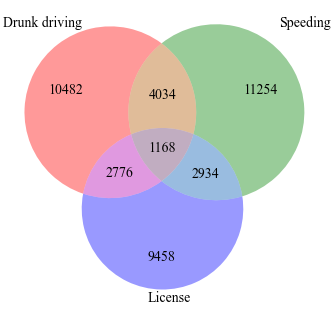

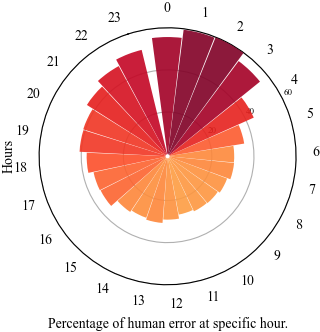

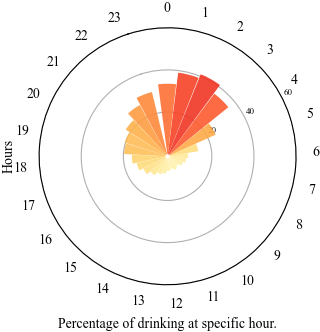

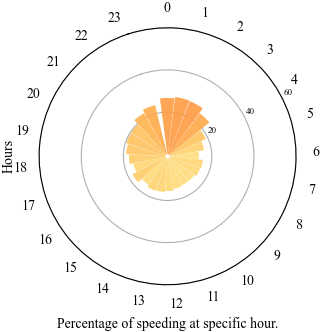

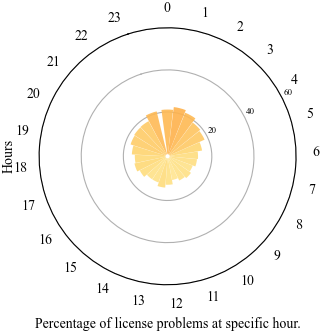

In [46]:
# 
figsize = (6.75/2,6.75/2)

### Trying Venn Diagram of total numbers
quot_drunk = len(drivers[drivers['DR_DRINK']==1])
quot_speed = len(drivers[drivers['SPEEDREL'].isin([2,3,4,5,8])])
quot_license = len(drivers[(drivers['L_TYPE']==0) | (drivers['L_STATUS'].isin([0,1,2,3,4,7]))])

quot_drunkSpeed = len(drivers[(drivers['DR_DRINK']==1)   & (drivers['SPEEDREL'].isin([2,3,4,5,8])) ])
quot_speedLicense = len(drivers[(drivers['SPEEDREL'].isin([2,3,4,5,8])) & ((drivers['L_TYPE']==0) | (drivers['L_STATUS'].isin([0,1,2,3,4,7]))) ])
quot_drunkLicense = len(drivers[(drivers['DR_DRINK']==1) & ((drivers['L_TYPE']==0) | (drivers['L_STATUS'].isin([0,1,2,3,4,7]))) ])

quot_all = len(drivers[(drivers['DR_DRINK']==1) & (drivers['SPEEDREL'].isin([2,3,4,5,8])) & ((drivers['L_TYPE']==0) | (drivers['L_STATUS'].isin([0,1,2,3,4,7]))) ])

plt.figure(figsize=figsize)
venn3(subsets=(quot_drunk,quot_speed,quot_drunkSpeed,quot_license,quot_drunkLicense,quot_speedLicense,quot_all), set_labels=('', '', ''))
plt.text(0.5,0.5,'Speeding')
plt.text(-0.7,0.5,'Drunk driving')
plt.text(-0.07,-0.7,'License')
plt.savefig('plots/human error/venn_diagram.pdf')
plt.show()





### 'Clock plot'
### Code follows https://python-graph-gallery.com/web-circular-barplot-with-matplotlib/


### Settings we use for all: 

cmap = matplotlib.colormaps['YlOrRd']
#norm = matplotlib.colors.Normalize(vmin=LENGTHS.min(), vmax=LENGTHS.max())
minval = 0
maxval = 60

ylim_min = -1
ylim_max = 60
norm = matplotlib.colors.Normalize(minval, maxval)

COLORS = cmap(norm(LENGTHS))

ANGLES = np.linspace(0.05, 2 * np.pi - 0.05, len(LENGTHS), endpoint=False)

LABELS = [str(23-i) for i in range(24)]

##'Specific'


LENGTHS = drivers[(drivers['HOUR']!=99) & (drivers['human_error']==1)].groupby(['HOUR']).size().values
TOTAL = drivers[(drivers['HOUR']!=99)].groupby(['HOUR']).size().values
LENGTHS = 100*(LENGTHS / TOTAL) #Normalize
LENGTHS = LENGTHS[::-1]

COLORS = cmap(norm(LENGTHS))



# Cumulative length


fig, ax = plt.subplots(figsize=figsize,subplot_kw={"projection": "polar"})
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.set_theta_offset(1.2 * np.pi / 2)
ax.set_ylim(ylim_min,ylim_max)

ax.bar(ANGLES, LENGTHS, color=COLORS, alpha=0.9, width=0.25, zorder=12)

ax.set_xticks(ANGLES)
ax.set_xticklabels(LABELS)

ax.xaxis.grid(False)

ax.set_yticks([20,40,60])
ax.set_yticklabels([])
PAD = 3
ax.text(-0.9 * np.pi / 2, 20 + PAD, "20", ha="center",size=6.5)
ax.text(-0.9 * np.pi / 2, 40 + PAD, "40", ha="center",size=6.5)
ax.text(-0.9 * np.pi / 2, 60 + PAD, "60", ha="center",size=6.5)


ax.set_xlabel('Percentage of human error at specific hour.')
ax.set_ylabel('Hours',labelpad=17)
#plt.title('Accidents by Hour')
plt.savefig('plots/human error/Clock_human_error.pdf')

plt.show()


### Same with drunk driving 

LENGTHS = drivers[(drivers['HOUR']!=99) & drivers['DR_DRINK']==1].groupby(['HOUR']).size().values
TOTAL = drivers[(drivers['HOUR']!=99)].groupby(['HOUR']).size().values
LENGTHS = 100*(LENGTHS / TOTAL)
LENGTHS = LENGTHS[::-1]
COLORS = cmap(norm(LENGTHS))
### 

# Cumulative length

fig, ax = plt.subplots(figsize=figsize,subplot_kw={"projection": "polar"})
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.set_theta_offset(1.2 * np.pi / 2)
ax.set_ylim(ylim_min,ylim_max)

ax.bar(ANGLES, LENGTHS, color=COLORS, alpha=0.9, width=0.25, zorder=12)

ax.set_xticks(ANGLES)
ax.set_xticklabels(LABELS)

ax.xaxis.grid(False)

ax.set_yticks([20,40,60])
ax.set_yticklabels([])
PAD = 3
ax.text(-0.9 * np.pi / 2, 20 + PAD, "20", ha="center",size=6.5)
ax.text(-0.9 * np.pi / 2, 40 + PAD, "40", ha="center",size=6.5)
ax.text(-0.9 * np.pi / 2, 60 + PAD, "60", ha="center",size=6.5)



ax.set_xlabel('Percentage of drinking at specific hour.')
ax.set_ylabel('Hours',labelpad=17)
#plt.title('Accidents with Drinking by Hour')

plt.savefig('plots/human error/Clock_drinking.pdf')
plt.show()




### CLOCK PLOT SPEEDING

LENGTHS = drivers[(drivers['HOUR']!=99) & drivers['speeding']==1].groupby(['HOUR']).size().values
#TOTAL = len(drivers[(drivers['HOUR']!=99) & drivers['speeding']==1])
LENGTHS = 100*(LENGTHS / TOTAL)
LENGTHS = LENGTHS[::-1]
COLORS = cmap(norm(LENGTHS))
### 

fig, ax = plt.subplots(figsize=figsize,subplot_kw={"projection": "polar"})
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.set_theta_offset(1.2 * np.pi / 2)
ax.set_ylim(ylim_min,ylim_max)

ax.bar(ANGLES, LENGTHS, color=COLORS, alpha=0.9, width=0.25, zorder=12)

ax.set_xticks(ANGLES)
ax.set_xticklabels(LABELS)

ax.xaxis.grid(False)

ax.set_yticks([20,40,60])
ax.set_yticklabels([])
PAD = 3
ax.text(-0.9 * np.pi / 2, 20 + PAD, "20", ha="center",size=6.5)
ax.text(-0.9 * np.pi / 2, 40 + PAD, "40", ha="center",size=6.5)
ax.text(-0.9 * np.pi / 2, 60 + PAD, "60", ha="center",size=6.5)



ax.set_xlabel('Percentage of speeding at specific hour.')
ax.set_ylabel('Hours',labelpad=17)
#plt.title('Accidents with Speeding by Hour')
plt.savefig('plots/human error/Clock_speeding.pdf')
plt.show()



### LICENSE BY TIME

LENGTHS = drivers[(drivers['HOUR']!=99) & drivers['license']==1].groupby(['HOUR']).size().values
#TOTAL = len(drivers[(drivers['HOUR']!=99) & drivers['license']==1])
LENGTHS = 100*(LENGTHS / TOTAL)
LENGTHS = LENGTHS[::-1]
COLORS = cmap(norm(LENGTHS))

fig, ax = plt.subplots(figsize=figsize,subplot_kw={"projection": "polar"})
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.set_theta_offset(1.2 * np.pi / 2)
ax.set_ylim(ylim_min,ylim_max)

ax.bar(ANGLES, LENGTHS, color=COLORS, alpha=0.9, width=0.25, zorder=12)

ax.set_xticks(ANGLES)
ax.set_xticklabels(LABELS)
ax.xaxis.grid(False)
ax.set_yticks([20,40,60])
ax.set_yticklabels([])
PAD = 3
ax.text(-0.9 * np.pi / 2, 20 + PAD, "20", ha="center",size=6.5)
ax.text(-0.9 * np.pi / 2, 40 + PAD, "40", ha="center",size=6.5)
ax.text(-0.9 * np.pi / 2, 60 + PAD, "60", ha="center",size=6.5)

#ax.spines["start"].set_color("none")
#ax.spines["polar"].set_color("none")

ax.set_xlabel('Percentage of license problems at specific hour.')
ax.set_ylabel('Hours',labelpad=17)
#plt.title('Accidents with License Problems by Hour')
plt.savefig('plots/human error/Clock_license.pdf')
plt.show()


### Colorbar


###Note: We are using 4 different colr

gradient = np.linspace(0, 100, 600)
gradient = np.vstack((gradient, gradient))
fix,axs = plt.subplots()
axs.imshow(gradient,cmap='YlOrRd')
axs.set_yticks([])
axs.set_xticks([0,199,399,599],[0,20,40,60])
#axs.set_title('Colorbar')
plt.savefig('plots/human error/Clock_colorbar.pdf')
plt.show()



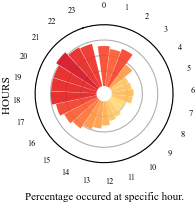

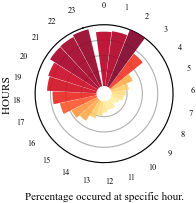

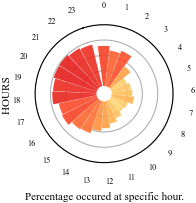

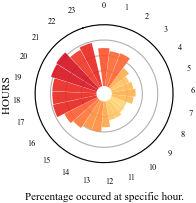

In [36]:
#### CLOCK PLOT NO LABEL


### 'Clock plot'
### Code follows https://python-graph-gallery.com/web-circular-barplot-with-matplotlib/

LENGTHS = drivers[(drivers['HOUR']!=99) & (drivers['human_error']==1)].groupby(['HOUR']).size().values
TOTAL = len(drivers[(drivers['HOUR']!=99) & (drivers['human_error']==1)])
LENGTHS = 100*(LENGTHS / TOTAL) #Normalize
LENGTHS = LENGTHS[::-1]

### 
ANGLES = np.linspace(0.05, 2 * np.pi - 0.05, len(LENGTHS), endpoint=False)

LABELS = [str(23-i) for i in range(24)]

# Cumulative length

cmap = matplotlib.colormaps['YlOrRd']
#norm = matplotlib.colors.Normalize(vmin=LENGTHS.min(), vmax=LENGTHS.max())
norm = matplotlib.colors.Normalize(0, 8)

COLORS = cmap(norm(LENGTHS))

fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.set_theta_offset(1.2 * np.pi / 2)
ax.set_ylim(-1,8)

ax.bar(ANGLES, LENGTHS, color=COLORS, alpha=0.9, width=0.25, zorder=12)

ax.set_xticks(ANGLES)
ax.set_xticklabels(LABELS)

ax.xaxis.grid(False)

ax.set_yticks([2,4,6,8])
ax.set_yticklabels([])


ax.set_xlabel('Percentage occured at specific hour.')
ax.set_ylabel('HOURS ',labelpad=17)
#plt.title('Accidents by Hour')
plt.savefig('plots/human error/Clock_human_error_no_label.pdf')

plt.show()








### Same with drunk driving 

LENGTHS = drivers[(drivers['HOUR']!=99) & drivers['DR_DRINK']==1].groupby(['HOUR']).size().values
TOTAL = len(drivers[(drivers['HOUR']!=99) & drivers['DR_DRINK']==1])
LENGTHS = 100*(LENGTHS / TOTAL)
LENGTHS = LENGTHS[::-1]
### 
ANGLES = np.linspace(0.05, 2 * np.pi - 0.05, len(LENGTHS), endpoint=False)

LABELS = [str(23-i) for i in range(24)]

# Cumulative length

cmap = matplotlib.colormaps['YlOrRd']
#norm = matplotlib.colors.Normalize(vmin=LENGTHS.min(), vmax=LENGTHS.max())
norm = matplotlib.colors.Normalize(0, 8)


COLORS = cmap(norm(LENGTHS))

fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.set_theta_offset(1.2 * np.pi / 2)
ax.set_ylim(-1,8)

ax.bar(ANGLES, LENGTHS, color=COLORS, alpha=0.9, width=0.25, zorder=12)

ax.set_xticks(ANGLES)
ax.set_xticklabels(LABELS)

ax.xaxis.grid(False)

ax.set_yticks([2,4,6,8])
ax.set_yticklabels([])

ax.set_xlabel('Percentage occured at specific hour.')
ax.set_ylabel('HOURS ',labelpad=17)
#plt.title('Accidents with Drinking by Hour')

plt.savefig('plots/human error/Clock_drinking_no_label.pdf')
plt.show()




### CLOCK PLOT SPEEDING

LENGTHS = drivers[(drivers['HOUR']!=99) & drivers['speeding']==1].groupby(['HOUR']).size().values
TOTAL = len(drivers[(drivers['HOUR']!=99) & drivers['speeding']==1])
LENGTHS = 100*(LENGTHS / TOTAL)
LENGTHS = LENGTHS[::-1]
### 
ANGLES = np.linspace(0.05, 2 * np.pi - 0.05, len(LENGTHS), endpoint=False)

LABELS = [str(23-i) for i in range(24)]

# Cumulative length

cmap = matplotlib.colormaps['YlOrRd']
#norm = matplotlib.colors.Normalize(vmin=LENGTHS.min(), vmax=LENGTHS.max())
norm = matplotlib.colors.Normalize(0, 8)

COLORS = cmap(norm(LENGTHS))

fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.set_theta_offset(1.2 * np.pi / 2)
ax.set_ylim(-1,8)

ax.bar(ANGLES, LENGTHS, color=COLORS, alpha=0.9, width=0.25, zorder=12)

ax.set_xticks(ANGLES)
ax.set_xticklabels(LABELS)

ax.xaxis.grid(False)

ax.set_yticks([2,4,6,8])
ax.set_yticklabels([])



ax.set_xlabel('Percentage occured at specific hour.')
ax.set_ylabel('HOURS ',labelpad=17)
#plt.title('Accidents with Speeding by Hour')
plt.savefig('plots/human error/Clock_speeding_no_label.pdf')
plt.show()







### LICENSE BY TIME

LENGTHS = drivers[(drivers['HOUR']!=99) & drivers['license']==1].groupby(['HOUR']).size().values
TOTAL = len(drivers[(drivers['HOUR']!=99) & drivers['license']==1])
LENGTHS = 100*(LENGTHS / TOTAL)
LENGTHS = LENGTHS[::-1]
### 
ANGLES = np.linspace(0.05, 2 * np.pi - 0.05, len(LENGTHS), endpoint=False)

LABELS = [str(23-i) for i in range(24)]

# Cumulative length

cmap = matplotlib.colormaps['YlOrRd']
#norm = matplotlib.colors.Normalize(vmin=LENGTHS.min(), vmax=LENGTHS.max())
norm = matplotlib.colors.Normalize(0, 8)

COLORS = cmap(norm(LENGTHS))

fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.set_theta_offset(1.2 * np.pi / 2)
ax.set_ylim(-1,8)

ax.bar(ANGLES, LENGTHS, color=COLORS, alpha=0.9, width=0.25, zorder=12)

ax.set_xticks(ANGLES)
ax.set_xticklabels(LABELS)
ax.xaxis.grid(False)
ax.set_yticks([2,4,6,8])
ax.set_yticklabels([])

#ax.spines["start"].set_color("none")
#ax.spines["polar"].set_color("none")
ax.set_xlabel('Percentage occured at specific hour.')
ax.set_ylabel('HOURS ',labelpad=17)
#plt.title('Accidents with License Problems by Hour')
plt.savefig('plots/human error/Clock_license_no_label.pdf')
plt.show()


### Colorbar


###Note: We are using 4 different colr

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
fix,axs = plt.subplots()
axs.imshow(gradient,cmap='YlOrRd')
axs.set_yticks([])
axs.set_xticks([0,63,127,191,255],[0,2,4,6,8])
#axs.set_title('Colorbar')
plt.savefig('plots/human error/Clock_colorbar.pdf')
plt.show()









In [42]:
hour_val = drivers[drivers['HOUR']!=99].groupby(['HOUR']).size().values

In [43]:
hour_val

array([2196, 1913, 2067, 1578, 1337, 1726, 2172, 2074, 1680, 1642, 2006,
       2259, 2537, 2709, 3050, 3392, 3272, 3624, 3717, 3389, 3375, 3377,
       2877, 2609])

In [44]:
drivers[drivers['HOUR']!=99].groupby(['HOUR']).size()

HOUR
0     2196
1     1913
2     2067
3     1578
4     1337
5     1726
6     2172
7     2074
8     1680
9     1642
10    2006
11    2259
12    2537
13    2709
14    3050
15    3392
16    3272
17    3624
18    3717
19    3389
20    3375
21    3377
22    2877
23    2609
dtype: int64

In [45]:
drivers[drivers['AGE']==997]

,STATE_x,STATENAME_x,ST_CASE,PEDS,PERNOTMVIT,VE_TOTAL,VE_FORMS,PVH_INVL,PERSONS,PERMVIT,...,date,x,y,z,cluster,subregion2_code,human_error,speeding,license,drinking


0.13.1


/tmp/ipykernel_11038/1452836154.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  violin_set.loc[:,'error'] = 'total accidents'


[]

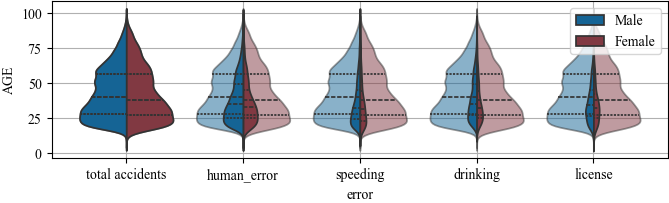

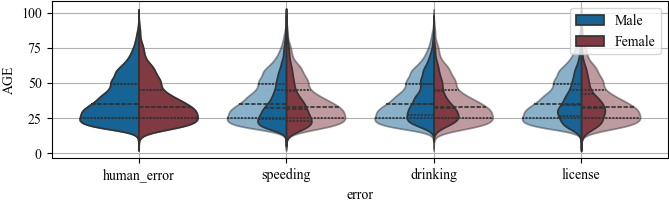

In [47]:
# Violin PLot
#total error
# version >0.13.0 is needed
# plot total accidents
print(sns.__version__)

gender_colors = [rgb.tue_blue,rgb.tue_red]

violin_set = drivers
violin_set.loc[:,'error'] = 'total accidents'
violin_set_total = violin_set.copy()

for i in ['human_error','speeding','drinking','license']:
    temp = drivers[drivers[i]==1]
    temp.loc[:,'error'] = i
    violin_set = pd.concat([violin_set,temp],ignore_index=True)
    temp = drivers
    temp.loc[:,'error'] = i
    violin_set_total = pd.concat([violin_set_total,temp],ignore_index=True)


#plt.figure()
f,ax = plt.subplots()
sns.violinplot(violin_set_total[(violin_set_total['AGE']<101) & (violin_set_total['SEXNAME'].isin(['Male','Female']))],x='error',split=True,y='AGE',hue='SEXNAME',ax=ax,density_norm='count',hue_order=['Male','Female'],inner='quart',legend=False,bw_adjust=1,palette=gender_colors)
for i in range(len(ax.collections)):
    ax.collections[i].set_alpha(0.5)
sns.violinplot(violin_set[(violin_set['AGE']<101) & (violin_set['SEXNAME'].isin(['Male','Female']))],x='error',split=True,y='AGE',hue='SEXNAME',ax=ax,density_norm='count',hue_order=['Male','Female'],inner='quart',bw_adjust=1,palette=gender_colors)
plt.legend()
ax.set_axisbelow(True)
plt.grid(which='major')
if save_fig == True:
    plt.savefig('plots/human error/total_accidents_vs_human error-violin_plot.pdf')
plt.plot()


violin_set = pd.DataFrame()
violin_set_total = violin_set.copy()

for i in ['human_error','speeding','drinking','license']:
    temp = drivers[drivers[i]==1]
    temp.loc[:,'error'] = i
    violin_set = pd.concat([violin_set,temp],ignore_index=True)
    temp = drivers[drivers['human_error']==1]
    temp.loc[:,'error'] = i
    violin_set_total = pd.concat([violin_set_total,temp],ignore_index=True)


#plt.figure()
f,ax = plt.subplots()
sns.violinplot(violin_set_total[(violin_set_total['AGE']<101) & (violin_set_total['SEXNAME'].isin(['Male','Female']))],x='error',split=True,y='AGE',hue='SEXNAME',ax=ax,density_norm='count',hue_order=['Male','Female'],inner='quart',legend=False,bw_adjust=1,palette=gender_colors)
for i in range(len(ax.collections)):
    ax.collections[i].set_alpha(0.5)
sns.violinplot(violin_set[(violin_set['AGE']<101) & (violin_set['SEXNAME'].isin(['Male','Female']))],x='error',split=True,y='AGE',hue='SEXNAME',ax=ax,density_norm='count',hue_order=['Male','Female'],inner='quart',bw_adjust=1,palette=gender_colors)

ax.set_axisbelow(True)
plt.grid(which='major')
plt.legend()
if save_fig == True:
    plt.savefig('plots/human error/human_error_vs_part-violin_plot.pdf')
plt.plot()

39.088175892775176


<Figure size 675x208.586 with 0 Axes>

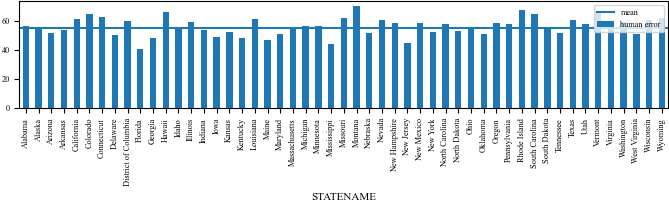

In [47]:


accidents_state['human_error_percent'] = accidents_state['human_error']/accidents_state['CASES']*100
print(accidents[accidents['human_error']==1].shape[0]/accidents.shape[0]*100)

plt.figure()
accidents_state.plot(kind='bar',x='STATENAME',y='human_error_percent',label='human error')
plt.axhline(accidents[accidents['human_error']==1].groupby('ST_CASE').first().shape[0]/accidents.groupby('ST_CASE').first().shape[0]*100,label='mean')

plt.legend()
plt.show()

       Female    Male  Not Reported  Reported as Unknown
1.0       NaN     NaN           NaN                  NaN
5.0       0.0     1.0           0.0                  0.0
9.0       2.0     4.0           0.0                  0.0
13.0     22.0    65.0           0.0                  0.0
17.0    782.0  1723.0           8.0                  0.0
21.0   1424.0  3896.0           9.0                  2.0
25.0   1445.0  4067.0           4.0                  3.0
29.0   1420.0  3968.0           6.0                  2.0
33.0   1283.0  3747.0          11.0                  1.0
37.0   1208.0  3259.0           6.0                  0.0
41.0    984.0  2981.0           6.0                  1.0
45.0    875.0  2689.0           7.0                  0.0
49.0    801.0  2729.0           1.0                  0.0
53.0    811.0  2692.0           4.0                  1.0
57.0    785.0  2666.0           1.0                  0.0
61.0    733.0  2510.0           1.0                  0.0
65.0    613.0  1959.0          

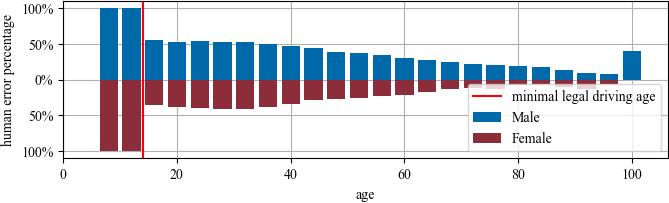

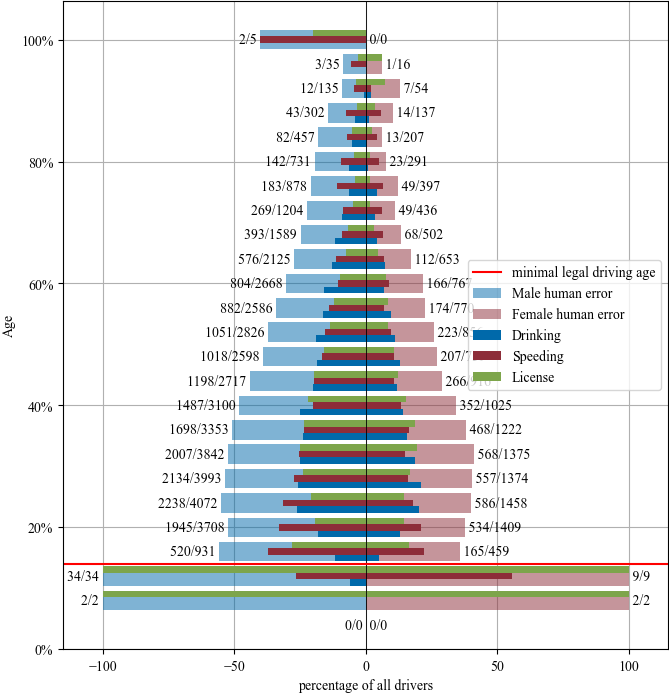

In [48]:
bins = 4
offset = 13%bins

length = 100+bins

empty_frame = pd.DataFrame(0,index=np.arange(length),columns=drivers['SEXNAME'].unique())

total_counts = (empty_frame+drivers.groupby(['AGE','SEXNAME']).size().unstack()).fillna(0).iloc[:length].rolling(bins).sum().set_index(empty_frame.index-bins/2+1)
count_human_error = (empty_frame+drivers[drivers['human_error']==1].groupby(['AGE','SEXNAME']).size().unstack()).fillna(0).iloc[:length].rolling(bins).sum().set_index(empty_frame.index-bins/2+1).div(total_counts)*100
total_counts_human_error = (empty_frame+drivers[drivers['human_error']==1].groupby(['AGE','SEXNAME']).size().unstack()).fillna(0).iloc[:length].rolling(bins).sum().set_index(empty_frame.index-bins/2+1)

count_alcohol = (empty_frame+drivers[drivers['drinking']==1].groupby(['AGE','SEXNAME']).size().unstack()).fillna(0).iloc[:length].rolling(bins).sum().set_index(empty_frame.index-bins/2+1).div(total_counts)*100
count_speeding = (empty_frame+drivers[drivers['speeding']==1].groupby(['AGE','SEXNAME']).size().unstack()).fillna(0).iloc[:length].rolling(bins).sum().set_index(empty_frame.index-bins/2+1).div(total_counts)*100
count_license = (empty_frame+drivers[drivers['license']==1].groupby(['AGE','SEXNAME']).size().unstack()).fillna(0).iloc[:length].rolling(bins).sum().set_index(empty_frame.index-bins/2+1).div(total_counts)*100
total_counts_error = 1/np.sqrt(total_counts)*100

print(total_counts.iloc[offset+1::bins])

def major_formatter(x, pos):
    label = str(-int(x))+'%' if x < 0 else str(int(x))+'%'
    return label


ax = plt.subplot()
#count_human_error[['Male','Female']].plot(kind='bar')
#plt.title('human error')
ax.bar(count_human_error['Male'].iloc[offset::bins].index,count_human_error['Male'].iloc[offset::bins],width=0.8*bins,label='Male',color=rgb.tue_blue)
ax.bar(count_human_error['Female'].iloc[offset::bins].index,-1*count_human_error['Female'].iloc[offset::bins],width=0.8*bins,label='Female',color=rgb.tue_red)
#ax.yaxis.set_major_formatter(tck.PercentFormatter())
#ax.axhline(0,color='black',linewidth=0.6)#,alpha=0.5)
ax.axvline(14,color='r',label='minimal legal driving age')
#ax.axvline(21,color='b',label='minimal legal drinking age')
ax.yaxis.set_major_formatter(major_formatter)
plt.ylabel('human error percentage')
plt.xlabel('age')
plt.legend()
ax.set_axisbelow(True)
plt.grid(which='major')
plt.xlim(0,None)
if save_fig == True:
    plt.savefig('plots/human error/human_error-age-splitted_gender.pdf')
plt.show()


categories = 3
height = 0.8*bins/categories

f = plt.figure(figsize=(6.75,7))
ax = f.add_subplot(111)
#count_human_error[['Male','Female']].plot(kind='bar')
#plt.title('Human error')
ax.barh(count_human_error['Male'].iloc[offset::bins].index,-count_human_error['Male'].iloc[offset::bins],label='Male human error',color=rgb.tue_blue,height=0.8*bins,alpha=0.5)
ax.barh(count_human_error['Female'].iloc[offset::bins].index,count_human_error['Female'].iloc[offset::bins],label='Female human error',color=rgb.tue_red,height=0.8*bins,alpha=0.5)
#ax.errorbar(-count_human_error['Male'].iloc[offset::bins],count_human_error['Male'].iloc[offset::bins].index,xerr=total_counts_error['Male'].iloc[offset::bins],capsize=bins*1.2,fmt='o')
#ax.errorbar(count_human_error['Female'].iloc[offset::bins],count_human_error['Female'].iloc[offset::bins].index,xerr=total_counts_error['Female'].iloc[offset::bins],capsize=bins*1.2,fmt='o')
for i in range(1,count_human_error['Male'].iloc[offset::bins].size):
    ax.text(-count_human_error['Male'].fillna(0).iloc[offset+bins*i],count_human_error['Male'].iloc[offset::bins].index[i],
            str(total_counts_human_error['Male'].iloc[offset+bins*i].astype(int))+'/'+str(total_counts['Male'].iloc[offset+bins*i].astype(int))+' ',
            horizontalalignment='right',verticalalignment='center')
    ax.text(count_human_error['Female'].fillna(0).iloc[offset+bins*i],count_human_error['Female'].iloc[offset::bins].index[i],
            ' '+str(total_counts_human_error['Female'].iloc[offset+bins*i].astype(int))+'/'+str(total_counts['Female'].iloc[offset+bins*i].astype(int)),
            verticalalignment='center')


ax.barh(count_alcohol['Male'].iloc[offset::bins].index-height,-count_alcohol['Male'].iloc[offset::bins],color=rgb.tue_blue,height=height,label='Drinking')
ax.barh(count_alcohol['Female'].iloc[offset::bins].index-height,count_alcohol['Female'].iloc[offset::bins],color=rgb.tue_blue,height=height)
ax.barh(count_speeding['Male'].iloc[offset::bins].index,-count_speeding['Male'].iloc[offset::bins],color=rgb.tue_red,height=height,label='Speeding')
ax.barh(count_speeding['Female'].iloc[offset::bins].index,count_speeding['Female'].iloc[offset::bins],color=rgb.tue_red,height=height)
ax.barh(count_license['Male'].iloc[offset::bins].index+height,-count_license['Male'].iloc[offset::bins],color=rgb.tue_green,height=height,label='License')
ax.barh(count_license['Female'].iloc[offset::bins].index+height,count_license['Female'].iloc[offset::bins],color=rgb.tue_green,height=height)
ax.yaxis.set_major_formatter(tck.PercentFormatter())
ax.axvline(0,color='black',linewidth=0.6)#,alpha=0.5)
ax.axhline(14,color='r',label='minimal legal driving age')
#ax.axvline(21,color='b',label='minimal legal drinking age')
#ax.xaxis.set_major_formatter(major_formatter)
plt.xlabel('percentage of all drivers')
plt.ylabel('Age')
plt.legend()
ax.set_axisbelow(True)
plt.grid(which='major')
plt.ylim(0,None)
plt.xlim(-115,115)
if save_fig == True:
    plt.savefig('plots/human error/human_error-age-splitted_gender-horizontal.pdf')
plt.show()

/tmp/ipykernel_11038/3165091987.py:20: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  US_state_shape[~US_state_shape['STATENAME'].isin(['Alaska','Hawaii'])].plot(column=plot_column,vmin=0,ax=ax,color=US_state_shape.loc[~US_state_shape['STATENAME'].isin(['Alaska','Hawaii']),'color'])
/tmp/ipykernel_11038/3165091987.py:28: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  US_state_shape[US_state_shape['STATENAME']=='Alaska'].plot(column=plot_column,vmin=0,ax=alaska_ax,color=US_state_shape.loc[US_state_shape['STATENAME']=='Alaska','color'])
/tmp/ipykernel_11038/3165091987.py:37: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  US_state_shape[US_state_shape['STATENAME']=='Hawaii'].plot(column=plot_column,vmin=0,ax=hawaii_ax,color=US_state_shape.loc[US_state_shape['STATENAME']=='Hawaii','color'])


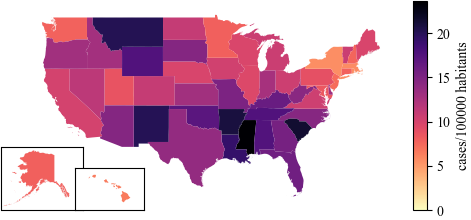

               STATENAME      temp
0                Alabama  1.480953
1                 Alaska  0.638646
2                Arizona  1.265840
3               Arkansas  1.722733
4             California  0.826084
5               Colorado  0.949210
6            Connecticut  0.638544
7               Delaware  1.126039
8   District of Columbia  0.460843
9                Florida  1.384226
10               Georgia  1.329313
11                Hawaii  0.533886
12                 Idaho  1.198818
13              Illinois  0.765046
14               Indiana  1.060027
15                  Iowa  0.875460
16                Kansas  1.063972
17              Kentucky  1.348704
18             Louisiana  1.590909
19                 Maine  0.826344
20              Maryland  0.702051
21         Massachusetts  0.473899
22              Michigan  0.878443
23             Minnesota  0.666523
24           Mississippi  1.891221
25              Missouri  1.244305
26               Montana  1.747500
27              Nebr

In [49]:
# better geoplot USA test section:
US_state_shape['human_error_perc'] = US_state_shape['human_error']/US_state_shape['CASES']*100

plot_column = 'CASES/100000_gov'
plot_label = 'cases/100000 habitants'

fig, ax = plt.subplots()
#plt.title('total cases in states of US')
ax.axis('off')
fig = ax.get_figure()
cbax = fig.add_axes([0.8, 0, 0.02, 1]) 
sm = plt.cm.ScalarMappable(cmap=plt.cm.magma_r,
                 norm=plt.Normalize(vmin=0, vmax=US_state_shape[plot_column].max()))
cbar = fig.colorbar(sm,cax=cbax,label=plot_label)
norm = mcolors.Normalize(vmin=0, vmax=US_state_shape[plot_column].max(), clip=True)


mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.magma_r)
US_state_shape['color'] = US_state_shape[plot_column].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
US_state_shape[~US_state_shape['STATENAME'].isin(['Alaska','Hawaii'])].plot(column=plot_column,vmin=0,ax=ax,color=US_state_shape.loc[~US_state_shape['STATENAME'].isin(['Alaska','Hawaii']),'color'])


# Add Alaska Axis (x, y, width, height)
alaska_ax = fig.add_axes([0.1, 0, 0.3, 0.3])
alaska_ax.set_xlim(-180,-120)
alaska_ax.set_xticks([])
alaska_ax.set_yticks([])
US_state_shape[US_state_shape['STATENAME']=='Alaska'].plot(column=plot_column,vmin=0,ax=alaska_ax,color=US_state_shape.loc[US_state_shape['STATENAME']=='Alaska','color'])


# Add Hawaii Axis(x, y, width, height)
hawaii_ax = fig.add_axes([.25, 0, 0.2, 0.2])
hawaii_ax.set_xlim(-162,-153)
hawaii_ax.set_ylim(18,23)
hawaii_ax.set_xticks([])
hawaii_ax.set_yticks([])
US_state_shape[US_state_shape['STATENAME']=='Hawaii'].plot(column=plot_column,vmin=0,ax=hawaii_ax,color=US_state_shape.loc[US_state_shape['STATENAME']=='Hawaii','color'])

# show and save fig
if save_fig == True:
    plt.savefig('plots/total_accidents_100000-state.pdf')
plt.show()

accidents_state['temp'] = accidents_state['CASES']/accidents_state['CASES'].sum()*accidents_state['population'].sum()/accidents_state['population']
print(accidents_state[['STATENAME','temp']])

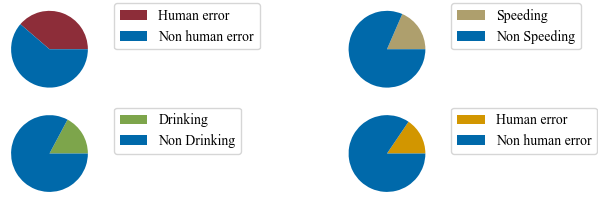

In [50]:
### Pie plots 

### Prevalence bar plot 
tot_acc = len(drivers)
tot_err =  len(drivers[drivers['human_error']==1])
tot_speed = len(drivers[drivers['speeding']==1])
tot_drink = len(drivers[drivers['drinking']==1])
tot_license = len(drivers[drivers['license']==1])

fig,axs = plt.subplots(2,2)

patches1, texts1 = axs[0][0].pie([tot_err,tot_acc-tot_err],colors=[rgb.tue_red,rgb.tue_blue])
axs[0][0].legend(patches1, ['Human error','Non human error'],bbox_to_anchor=(1.1, 1.05))
#axs[0][0].set_title('Human error')

patches2, texts2 =  axs[0][1].pie([tot_speed,tot_acc-tot_speed],colors=[rgb.tue_gold,rgb.tue_blue])
axs[0][1].legend(patches2, ['Speeding','Non Speeding'],bbox_to_anchor=(1.1, 1.05))
#axs[0][1].set_title('Speeding')


patches3, texts3 = axs[1][0].pie([tot_drink,tot_acc-tot_drink],colors=[rgb.tue_green,rgb.tue_blue])
axs[1][0].legend(patches3, ['Drinking','Non Drinking'],bbox_to_anchor=(1.1, 1.05))
#axs[1][0].set_title('Drinking')


patches4, texts4 = axs[1][1].pie([tot_license,tot_acc - tot_license],colors=[rgb.tue_orange,rgb.tue_blue])
axs[1][1].legend(patches4, ['Human error','Non human error'],bbox_to_anchor=(1.1, 1.05))
#axs[1][1].set_title('License')


#fig.suptitle('Prevalence of human error criteria in the whole dataset')
plt.show()

### TODO Change color scheme, maybe we also have to add numbers? not sure.

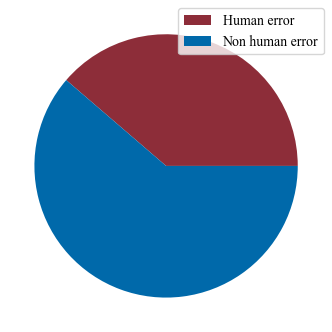

Fraction of human error:  0.3869860764481807


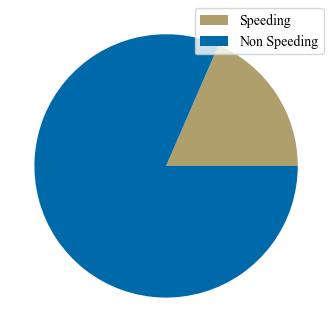

Fraction of speeding:  0.18478260869565216


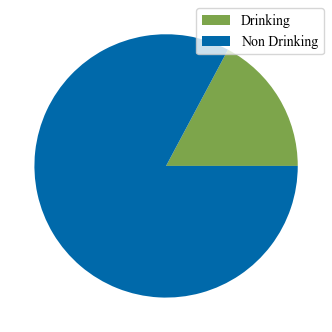

Fraction of drinking:  0.1721069223696309


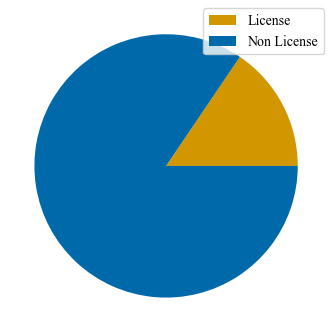

Fraction of license  0.1552935767765664


In [51]:

figsize=(6.75/2,6.75/2)
### Separate Pie Plots 
tot_acc = len(drivers)
tot_err =  len(drivers[drivers['human_error']==1])
tot_speed = len(drivers[drivers['speeding']==1])
tot_drink = len(drivers[drivers['drinking']==1])
tot_license = len(drivers[drivers['license']==1])

### Plot 1 
plt.figure(figsize=figsize)
patches1, texts1 = plt.pie([tot_err,tot_acc-tot_err],colors=[rgb.tue_red,rgb.tue_blue])
plt.legend(patches1, ['Human error','Non human error'],loc='upper right')
if save_fig == True:
    plt.savefig('plots/human error/pie_human_error.pdf')
plt.show()
print('Fraction of human error: ', (tot_err) / (tot_acc))

plt.figure(figsize=figsize)
patches2, texts2 =  plt.pie([tot_speed,tot_acc-tot_speed],colors=[rgb.tue_gold,rgb.tue_blue])
plt.legend(patches2, ['Speeding','Non Speeding'],loc='upper right')
if save_fig == True:
    plt.savefig('plots/human error/pie_speeding.pdf')
plt.show()
print('Fraction of speeding: ', (tot_speed) / (tot_acc))


plt.figure(figsize=figsize)
patches3, texts3 = plt.pie([tot_drink,tot_acc-tot_drink],colors=[rgb.tue_green,rgb.tue_blue])
plt.legend(patches3, ['Drinking','Non Drinking'],loc='upper right')
if save_fig == True:
    plt.savefig('plots/human error/pie_drinking.pdf')
plt.show()
print('Fraction of drinking: ', (tot_drink) / (tot_acc))

plt.figure(figsize=figsize)
patches4, texts4 = plt.pie([tot_license,tot_acc - tot_license],colors=[rgb.tue_orange,rgb.tue_blue])
plt.legend(patches4, ['License','Non License'],loc='upper right')
if save_fig == True:
    plt.savefig('plots/human error/pie_license.pdf')
plt.show()
print('Fraction of license ', (tot_license) / (tot_acc))

